# TVB-ANNarchy: Bridging multiscale activity by co-simulation

## Step-by-step learn how to perform a co-simulation embedding spiking neural networks into large-scale brain networks using TVB.

## Izhikevich Spiking network model in ANNarchy

For every neuron $i$ in region node $n$ modelled in ANNarchy as a spiking network:

Membrane potential:

$ \dot{V}_m = n_2V_m^2 + n_1V_m + n_0140 - U_m/C $

$\;\;\;\;\;\;\;- g_{AMPA}(V_m-E_{AMPA}) - g_{GABA}(V_m-E_{GABA}) - g_{BASE}V_m + I_e $

where the conductances follow the equations:

$ \dot{g}_{AMPA} = - g_{AMPA} / \tau_{AMPA} + \left[\sum_k \delta(t-t_k) \right]_{Exc}$

$ \dot{g}_{GABA} = - g_{GABA} / \tau_{GABA} + \left[\sum_k \delta(t-t_k) \right]_{Inh}$

$ \dot{g}_{BASE} = - g_{BASE} / \tau_{BASE} + \left[\sum_k \delta(t-t_k) \right]_{BASE}$

and recovery variable:

$ \dot{U}_m = a(bV_m - U_m)$


When $ V_m > V_{th} $ , $ V_m $ is set to $ c $, and $ U_m $ is incremented by $ d $.

# WORKFLOW:

In [1]:
import os
from collections import OrderedDict
import time
import numpy as np

from tvb.basic.profile import TvbProfile
TvbProfile.set_profile(TvbProfile.LIBRARY_PROFILE)

from tvb_multiscale.tvb_annarchy.config import *

work_path = os.getcwd()
data_path = os.path.join(work_path.split("tvb_annarchy")[0], "data")
simulation_mode = "rs" # "stim"
outputs_path = os.path.join(work_path, "outputs/outputs_Izhikevich_annarchy")
sim_mode_path = os.path.join(outputs_path, "TVBcortex", simulation_mode)
config = Config(output_base=sim_mode_path)
config.figures.SHOW_FLAG = True 
config.figures.SAVE_FLAG = True
config.figures.FIG_FORMAT = 'png'
config.figures.DEFAULT_SIZE= config.figures.NOTEBOOK_SIZE
FIGSIZE = config.figures.DEFAULT_SIZE

from tvb_multiscale.core.plot.plotter import Plotter
plotter = Plotter(config.figures)

# For interactive plotting:
# %matplotlib notebook  

# Otherwise:
%matplotlib inline 

## 1. Load structural data <br> (minimally a TVB connectivity)  <br> & prepare TVB simulator  <br> (region mean field model, integrator, monitors etc)

In [2]:
from tvb.simulator.models.reduced_wong_wang_exc_io import ReducedWongWangExcIO

# ----------------------------------------------------------------------------------------------------------------
# ----Uncomment below to modify the simulator by changing the default options:--------------------------------------
# ----------------------------------------------------------------------------------------------------------------

from tvb.datatypes.connectivity import Connectivity
from tvb.simulator.cosimulator import CoSimulator
from tvb.simulator.integrators import HeunStochastic
from tvb.simulator.monitors import Raw  # , Bold, EEG


# 0. GPe_Left, 1. GPi_Left, 2. STN_Left, 3. Striatum_Left, 4. Thal_Left
BG_opt_matrix_weights = np.zeros((5, 5))
conn_mode = "subject" # "average"
if conn_mode == "average":
    weights_maith = np.array([1.93, 3.56, 1.46, 4.51, 3.52, 2.30, 2.34, 3.78, 1.98, 
                             1.30, 1.82, 3.56, 3.02, 1.78, 1.36, 2.27, 4.13, 2.74, 3.27])*1e-3  # controls
#     weights_maith = np.array([3.27, 3.80, 2.65, 3.66, 3.06, 3.06, 3.25, 4.02, 3.32, 
#                             2.98, 3.45, 3.64, 2.50, 2.12, 2.86, 2.79, 3.96, 3.69, 3.87])*1e-3   # patients
    # probs_maith = ????
else:
    import scipy.io as sio
    conn_path = os.path.join(data_path, "basal_ganglia_conn_incl_cortex")
    weights=sio.loadmat(os.path.join(conn_path,"OutputSim_Patient01.mat")) # weights start from index 19
    weights_maith = weights["X"][0, 19:] # these are indices 19 till 37
    probs_maith = weights["X"][0, :19] # these are indices 0 till 18

wdSNGPi = BG_opt_matrix_weights[3, 1] = weights_maith[0]
wiSNGPe = BG_opt_matrix_weights[3, 0] = weights_maith[1]
wGPeSTN = BG_opt_matrix_weights[0, 2] = weights_maith[2]
wSTNGPe = BG_opt_matrix_weights[2, 0] = weights_maith[3]
wSTNGPi = BG_opt_matrix_weights[2, 1] = weights_maith[4]
wGPeGPi = BG_opt_matrix_weights[0, 1] = weights_maith[5]  
wGPiTh = BG_opt_matrix_weights[1, 4] = weights_maith[8]
wThdSN = BG_opt_matrix_weights[4, 3] = weights_maith[10] # Th -> dSN
    
sliceBGnet = slice(0,5)

wGPeGPe = weights_maith[6]   # "GPe" -> "GPe" 
wGPiGPi = weights_maith[7]   # "GPi" -> "GPi" 
wThiSN = weights_maith[9]    # "Eth" -> "IiSN" 

wdSNdSN = weights_maith[11]  # "IdSN" -> "IdSN" 
wiSNiSN = weights_maith[12]  # "IiSN" -> "IiSN" 
wCtxdSN = weights_maith[13]  # "CxE" -> "IdSN" 
wCtxiSN = weights_maith[14] # "CxE" -> "IiSN" 
wCtxSTN = weights_maith[15]  # "CxE" -> "Estn"
wCtxEtoI = weights_maith[16] # "CxE" -> "CxI"
wCtxItoE = weights_maith[17] # "CxI" -> "CxE"
wCtxItoI = weights_maith[18] # "CxI" -> "CxI"

pdSNGPi = probs_maith[0]
piSNGPe = probs_maith[1]
pGPeSTN = probs_maith[2]
pSTNGPe = probs_maith[3]
pSTNGPi = probs_maith[4]
pGPeGPi = probs_maith[5]  
pGPeGPe = probs_maith[6]  # "GPe" -> "GPe" 
pGPiGPi = probs_maith[7]  # "GPi" -> "GPi" 
pGPiTh = probs_maith[8]
pThiSN =  probs_maith[9]  # "Eth" -> "IiSN
pThdSN = probs_maith[10] # Th --> dSN
pdSNdSN = probs_maith[11] # "IdSN" -> "IdSN" 
piSNiSN = probs_maith[12] # "IiSN" -> "IiSN" 
pCtxdSN = probs_maith[13]  # "CxE" -> "IdSN" 
pCtxiSN = probs_maith[14] # "CxE" -> "IiSN" 
pCtxSTN = probs_maith[15]  # "CxE" -> "Estn"
# pCtxEtoI = probs_maith[16] # "CxE" -> "CxI"
# pCtxItoE = probs_maith[17] # "CxI" -> "CxE"
# pCtxItoI = probs_maith[18] # "CxI" -> "CxI"

loadedParams ={'dSNGPi_probs': probs_maith[0],
    	'dSNGPi_weights'  : weights_maith[0],
    	'iSNGPe_probs'   : probs_maith[1],
    	'iSNGPe_weights'  : weights_maith[1],
    	'GPeSTN_probs'   : probs_maith[2],
    	'GPeSTN_weights'  : weights_maith[2],
    	'STNGPe_probs'   : probs_maith[3],
    	'STNGPe_weights'  : weights_maith[3],
    	'STNGPi_probs'   : probs_maith[4],
    	'STNGPi_weights' : weights_maith[4],
    	'GPeGPi_probs'   : probs_maith[5],
    	'GPeGPi_weights'  : weights_maith[5],
    	'GPeGPe_probs'   : probs_maith[6],
    	'GPeGPe_weights'  : weights_maith[6],
    	'GPiGPi_probs'   : probs_maith[7],
    	'GPiGPi_weights'  : weights_maith[7],
    	'GPiThal_probs'   : probs_maith[8],
    	'GPiThal_weights'  : weights_maith[8],
    	'ThaliSN_probs'   : probs_maith[9],
    	'ThaliSN_weights'  : weights_maith[9],
    	'ThaldSN_probs'   : probs_maith[10],
    	'ThaldSN_weights'  : weights_maith[10],
    	'dSNdSN_probs'   : probs_maith[11],
    	'dSNdSN_weights'  : weights_maith[11],
    	'iSNiSN_probs'   : probs_maith[12],
    	'iSNiSN_weights'  : weights_maith[12],
    	'CtxdSN_probs'   : probs_maith[13],
    	'CtxdSN_weights'  : weights_maith[13],
    	'CtxiSN_probs'   : probs_maith[14],
    	'CtxiSN_weights'  : weights_maith[14],
    	'CtxSTN_probs'   : probs_maith[15],
    	'CtxSTN_weights'  : weights_maith[15],
    	'CtxECtxI_probs'    : probs_maith[16],
    	'CtxECtxI_weights'  : weights_maith[16],
    	'CtxICtxE_probs'    : probs_maith[17],
    	'CtxICtxE_weights'  : weights_maith[17],
    	'CtxICtxI_probs'   : probs_maith[18],
    	'CtxICtxI_weights'  : weights_maith[18],
        'CtxThal_weights': 0.0,
        'CtxThal_probs': 1.0}
print(loadedParams)

assert_loadedParams = dict(zip(loadedParams.values(), loadedParams.keys()))


{'dSNGPi_probs': 0.17029162198305128, 'dSNGPi_weights': 0.009132171887904406, 'iSNGPe_probs': 0.4074640914797783, 'iSNGPe_weights': 0.007663531694561243, 'GPeSTN_probs': 0.18478520214557648, 'GPeSTN_weights': 0.006760342903435231, 'STNGPe_probs': 0.4119542151689529, 'STNGPe_weights': 0.010754598900675774, 'STNGPi_probs': 0.2458414003252983, 'STNGPi_weights': 0.013566167578101158, 'GPeGPi_probs': 0.32317305132746693, 'GPeGPi_weights': 0.006238304376602173, 'GPeGPe_probs': 0.3238955348730087, 'GPeGPe_weights': 0.007731672264635564, 'GPiGPi_probs': 0.31747561842203137, 'GPiGPi_weights': 0.011985597293823957, 'GPiThal_probs': 0.25937364250421524, 'GPiThal_weights': 0.006650131419301033, 'ThaliSN_probs': 0.1753483198583126, 'ThaliSN_weights': 0.006984027139842511, 'ThaldSN_probs': 0.12791343107819556, 'ThaldSN_weights': 0.012284493483603, 'dSNdSN_probs': 0.44881010577082636, 'dSNdSN_weights': 0.008113504592329264, 'iSNiSN_probs': 0.20492168664932248, 'iSNiSN_weights': 0.013962633926421403, 

Connections between Thalami removed!:
 [[0.6059682  0.        ]
 [0.         0.31177142]]
Removing BG -> Cortex connections with max:
5561.70581402219
Removing Cortex -> Thalamus connections with summed weight:
11424.828627935316
Removing BG <- Cortex connections with max:
5202.36821426155

Left cortex connectome, after removing direct BG -> Cortex and intehemispheric BG <-> BG connections:


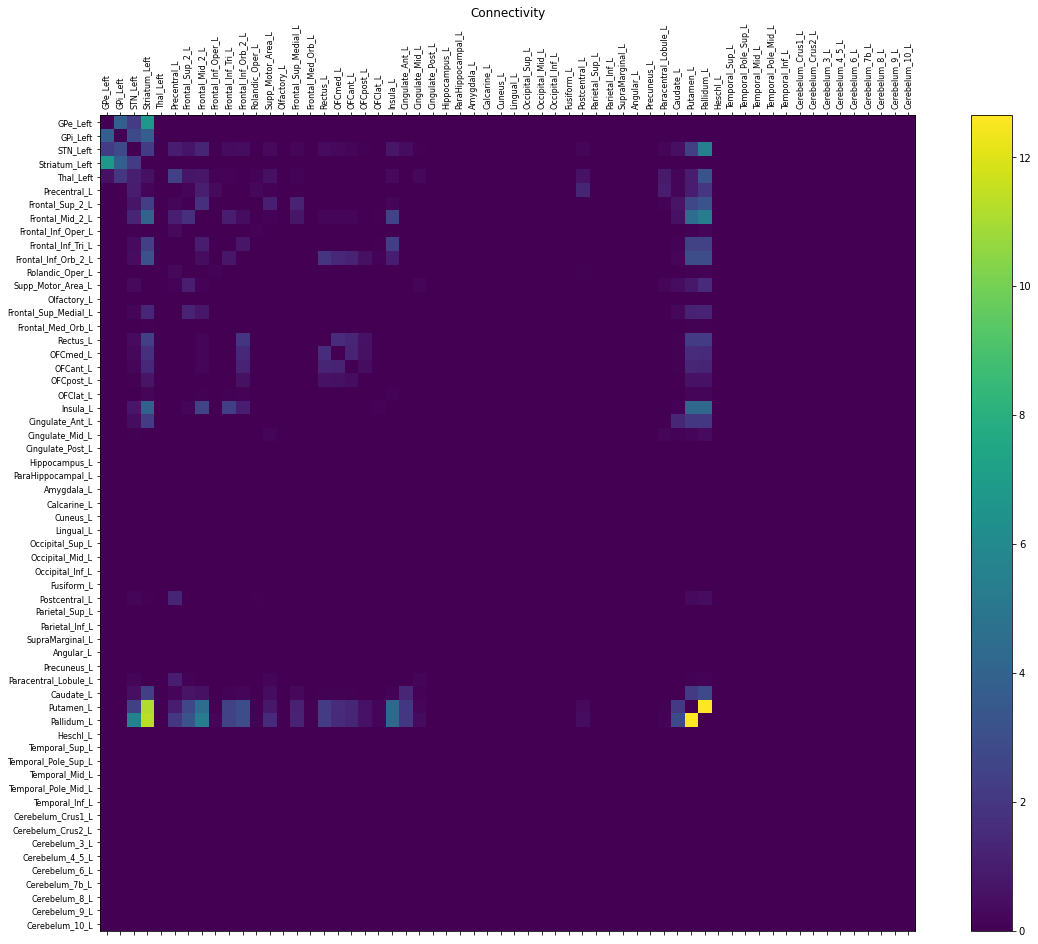

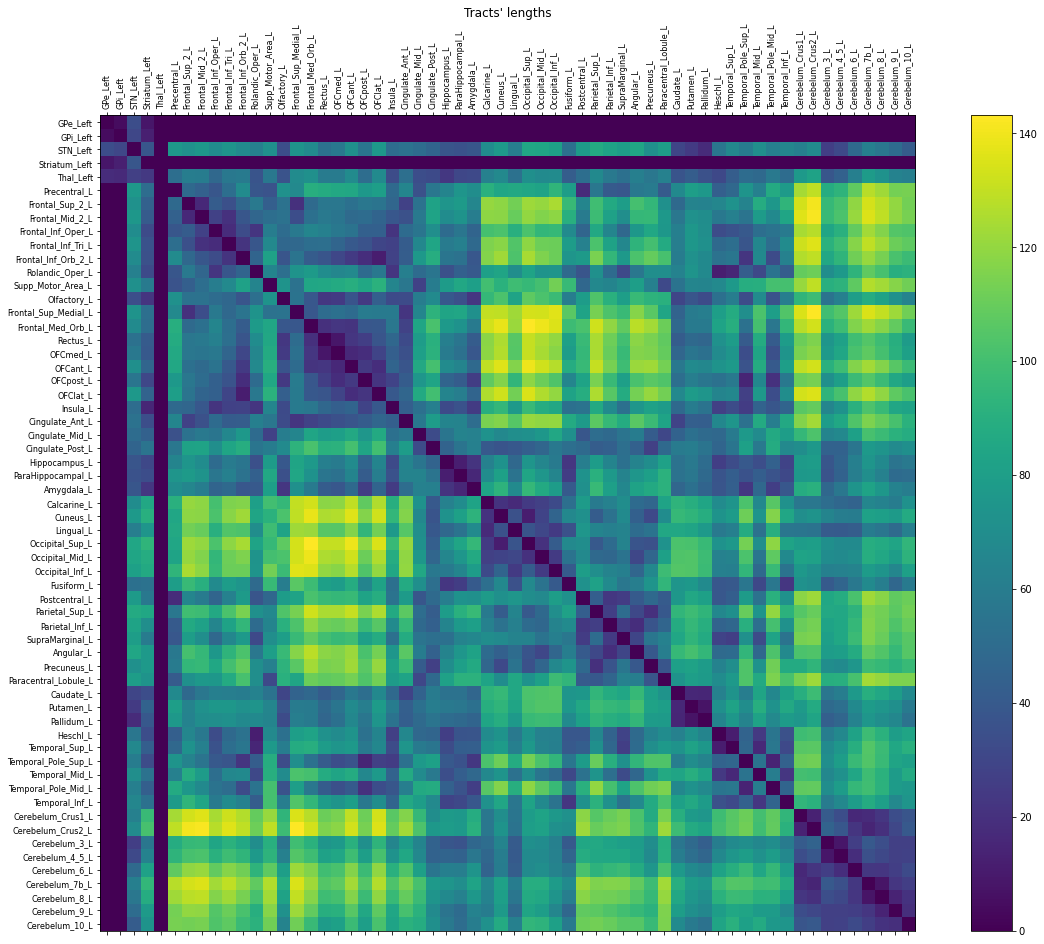

In [3]:
# Load full TVB connectome connectivity

conn_path = os.path.join(data_path, "basal_ganglia_conn")

#Load AAL atlas normative connectome including the Basal Ganglia regions from Petersen et al. atlas
wTVB = np.loadtxt(os.path.join(conn_path, "conn_denis_weights.txt"))
cTVB = np.loadtxt(os.path.join(conn_path, "aal_plus_BG_centers.txt"),usecols=range(1,3))
rlTVB = np.loadtxt(os.path.join(conn_path, "aal_plus_BG_centers.txt"),dtype="str", usecols=(0,))
tlTVB = np.loadtxt(os.path.join(conn_path, "BGplusAAL_tract_lengths.txt"))

# # ????Remove the second Thalamus????:
inds_Th = (rlTVB.tolist().index("Thalamus_L"), rlTVB.tolist().index("Thalamus_R"))
print("Connections between Thalami removed!:\n", wTVB[[8,9], :][:, inds_Th] / wTVB.max())
wTVB = np.delete(wTVB, inds_Th, axis=0)
wTVB = np.delete(wTVB, inds_Th, axis=1)
tlTVB = np.delete(tlTVB, inds_Th, axis=0)
tlTVB = np.delete(tlTVB, inds_Th, axis=1)
rlTVB = np.delete(rlTVB, inds_Th, axis=0)
cTVB = np.delete(cTVB, inds_Th, axis=0)

number_of_regions = len(rlTVB)
speed = np.array([4.0])
min_tt = speed.item() * 0.1
sliceBG = [0, 1, 2, 3, 6, 7]
sliceCortex = slice(10, number_of_regions)

# Remove BG -> Cortex connections
print("Removing BG -> Cortex connections with max:")
print(wTVB[sliceBG, :][:, sliceCortex].max())
wTVB[sliceBG, sliceCortex] = 0.0
tlTVB[sliceBG, sliceCortex] = min_tt

# Remove Cortex -> Thalamus connections
sliceThal = [8, 9]
print("Removing Cortex -> Thalamus connections with summed weight:")
print(wTVB[:, 4].sum())
wTVB[:, sliceThal] = 0.0
tlTVB[:, sliceThal] = min_tt

# Remove GPe/i <- Cortex connections
sliceBG = [0, 1, 2, 3]
print("Removing BG <- Cortex connections with max:")
print(wTVB[sliceCortex, :][:, sliceBG].max())
wTVB[sliceCortex, sliceBG] = 0.0
tlTVB[sliceCortex, sliceBG] = min_tt

connTVB = Connectivity(region_labels=rlTVB, weights=wTVB, centres=cTVB, tract_lengths=tlTVB, speed=speed)

# Normalize connectivity weights
connTVB.weights = connTVB.scaled_weights(mode="region")
connTVB.weights /= np.percentile(connTVB.weights, 99)

# Keep only left hemisphere and remove Vermis:
sliceLeft = slice(0, connTVB.number_of_regions -8, 2)

connLeft = Connectivity(region_labels=connTVB.region_labels[sliceLeft], 
                        centres=connTVB.centres[sliceLeft],
                        weights=connTVB.weights[sliceLeft][:, sliceLeft],
                        tract_lengths=connTVB.tract_lengths[sliceLeft][:, sliceLeft], 
                       speed=connTVB.speed)
connLeft.configure()

print("\nLeft cortex connectome, after removing direct BG -> Cortex and intehemispheric BG <-> BG connections:")
plotter.plot_tvb_connectivity(connLeft);



Left BG TVB network:


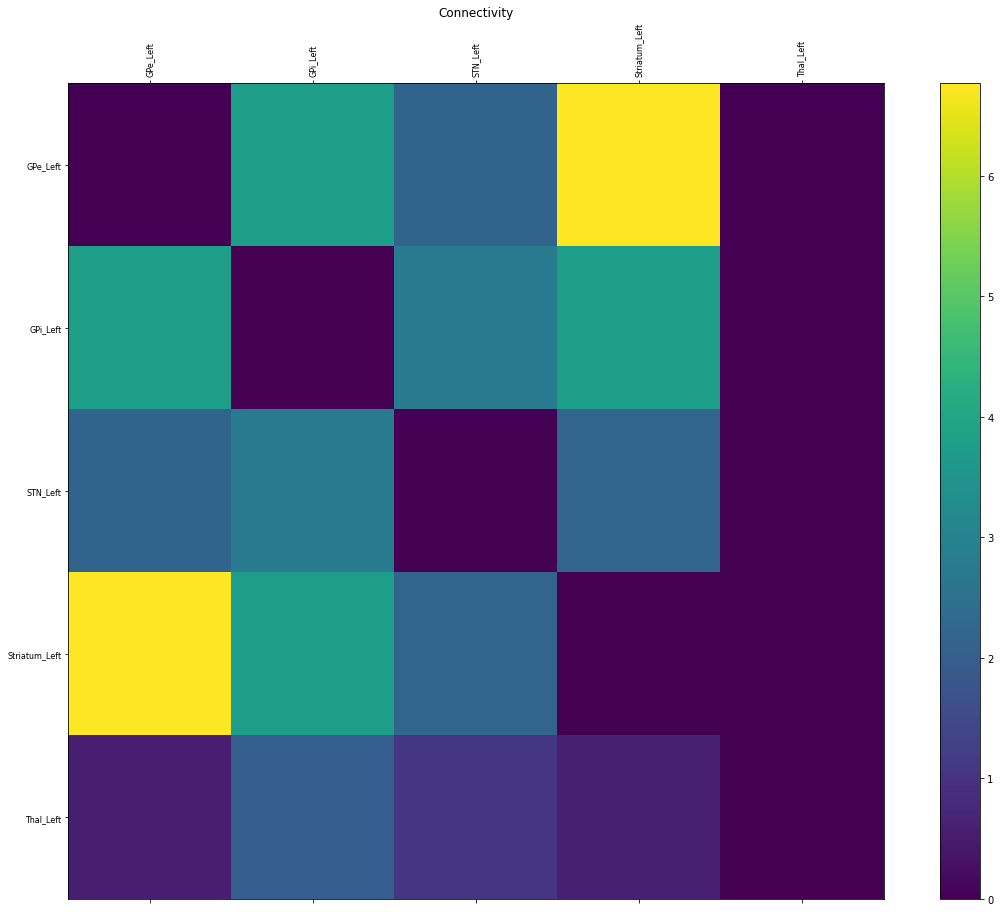

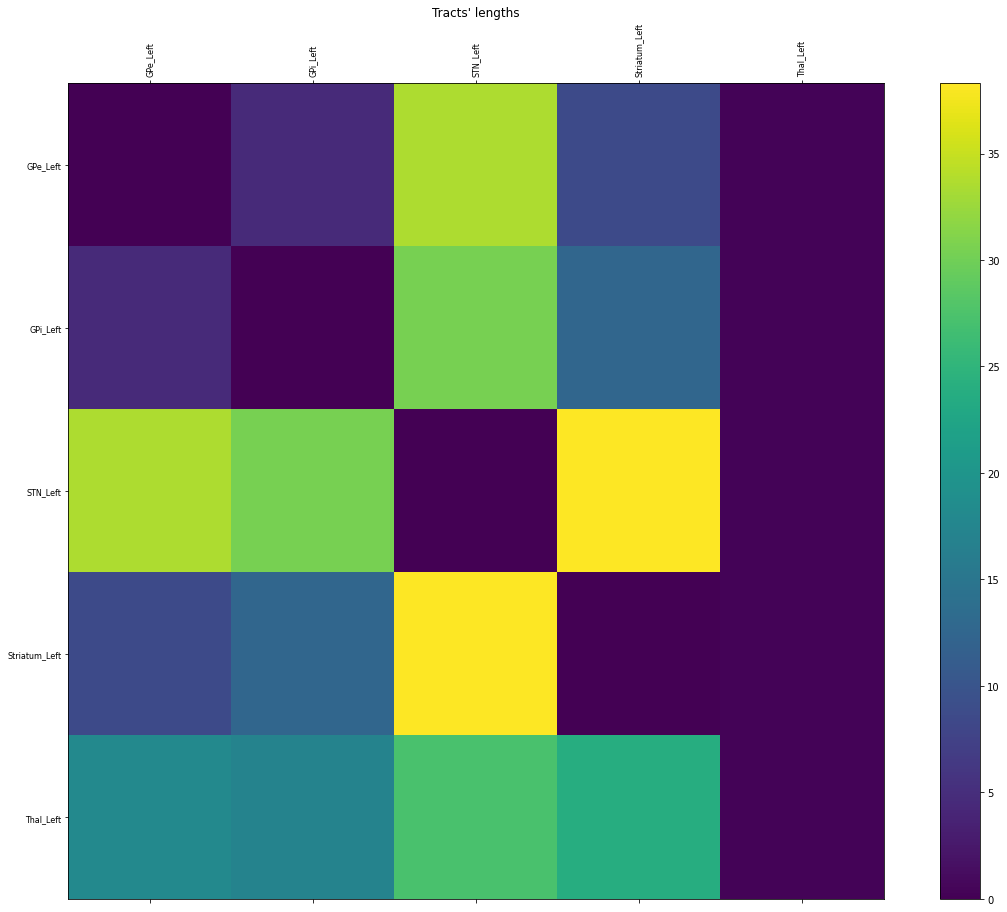

In [4]:
sliceBGnet = slice(0,5)
connTVBleftBG = Connectivity(region_labels=connLeft.region_labels[sliceBGnet], 
                             centres=connLeft.centres[sliceBGnet],
                             weights=connLeft.weights[sliceBGnet][:, sliceBGnet],
                             tract_lengths=connLeft.tract_lengths[sliceBGnet][:, sliceBGnet], 
                            speed=connLeft.speed)
connTVBleftBG.configure()

print("\nLeft BG TVB network:")
plotter.plot_tvb_connectivity(connTVBleftBG);


In [5]:
scaleBGoptTOtvb = np.percentile(BG_opt_matrix_weights, 95) /\
                  np.percentile(connTVBleftBG.weights, 95)
                  
print("Scaling factor of TVB BG network connectome to optimal one = %g" % scaleBGoptTOtvb)


Scaling factor of TVB BG network connectome to optimal one = 0.00194122



Left BG optimized network:


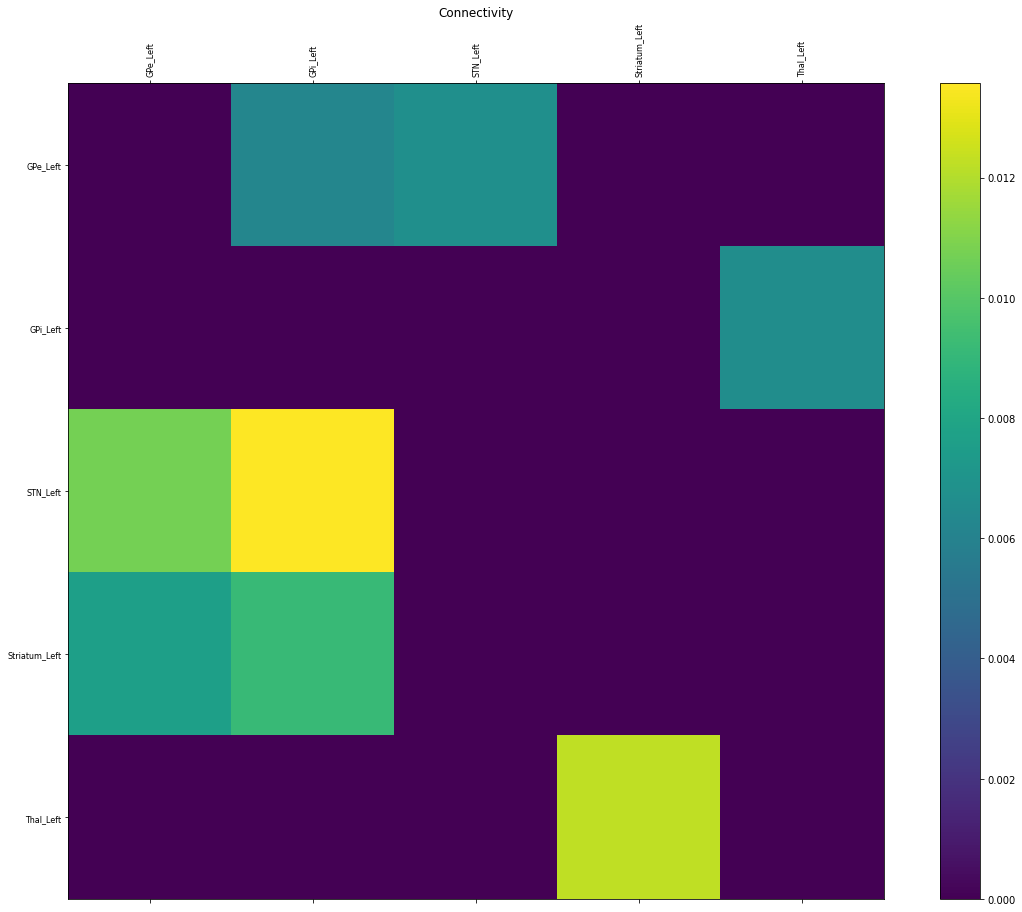

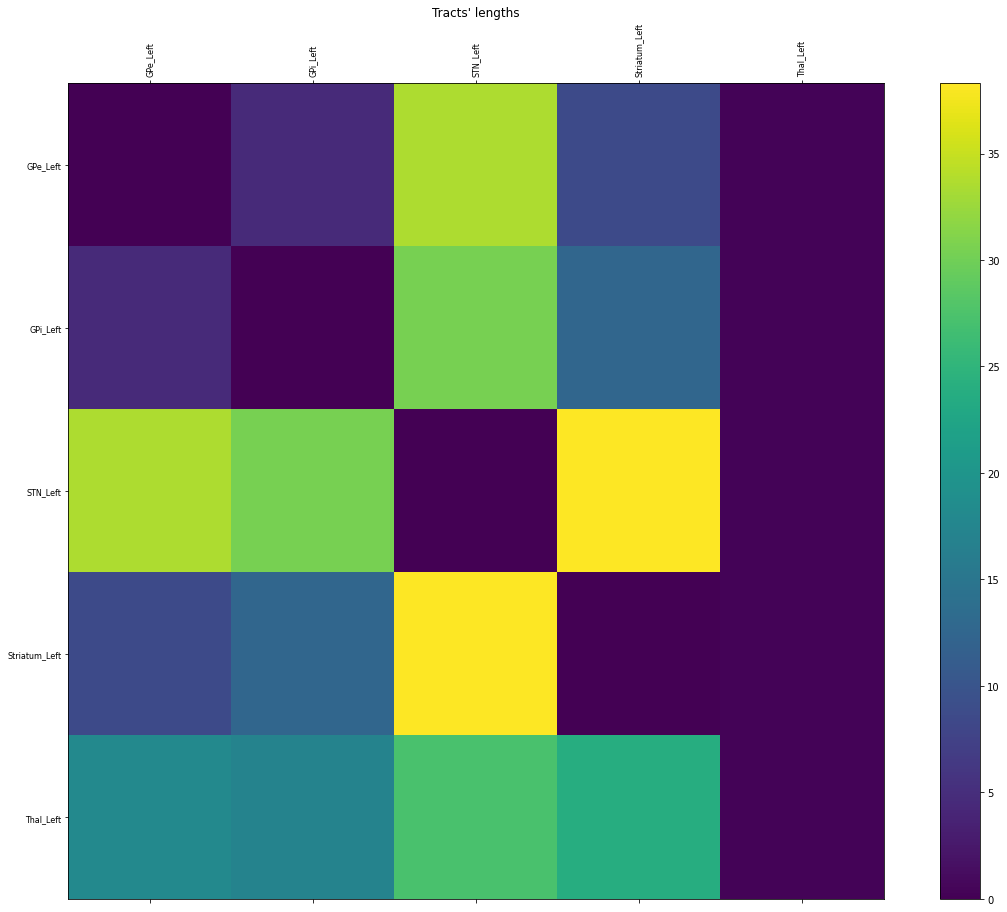

In [6]:
# Construct the final connectivity to use for simulation:
ww = scaleBGoptTOtvb * np.array(connLeft.weights)
ww[sliceBGnet, sliceBGnet] = BG_opt_matrix_weights

connectivity = Connectivity(region_labels=connLeft.region_labels, 
                            centres=connLeft.centres,
                            weights=ww, tract_lengths=connLeft.tract_lengths, 
                            speed=connLeft.speed)
connectivity.configure()

# Construct only the optimized BG connectivity only for plotting:
connBGopt = Connectivity(region_labels=connectivity.region_labels[sliceBGnet], 
                         centres=connectivity.centres[sliceBGnet],
                         weights=connectivity.weights[sliceBGnet][:, sliceBGnet],
                         tract_lengths=connectivity.tract_lengths[sliceBGnet][:, sliceBGnet], 
                         speed=connectivity.speed)
connBGopt.configure()

print("\nLeft BG optimized network:")
plotter.plot_tvb_connectivity(connBGopt);



Connectome used for simulations:


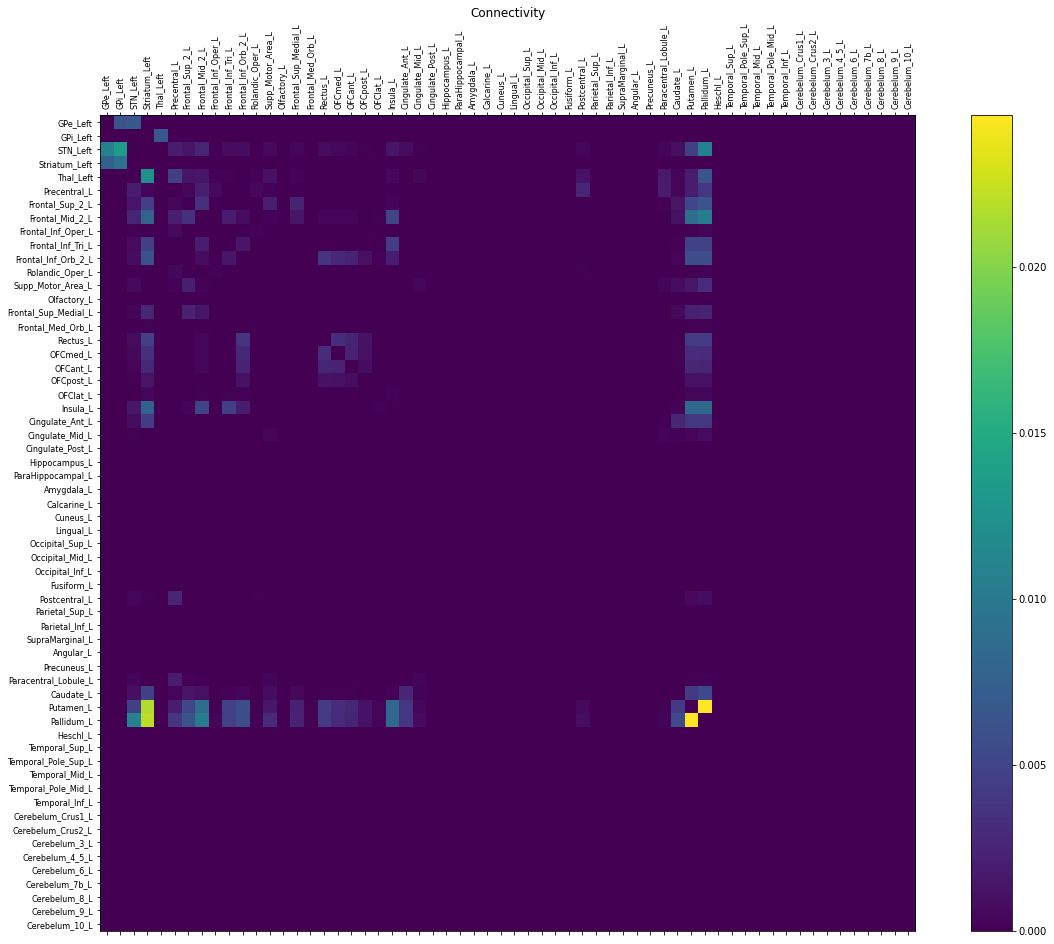

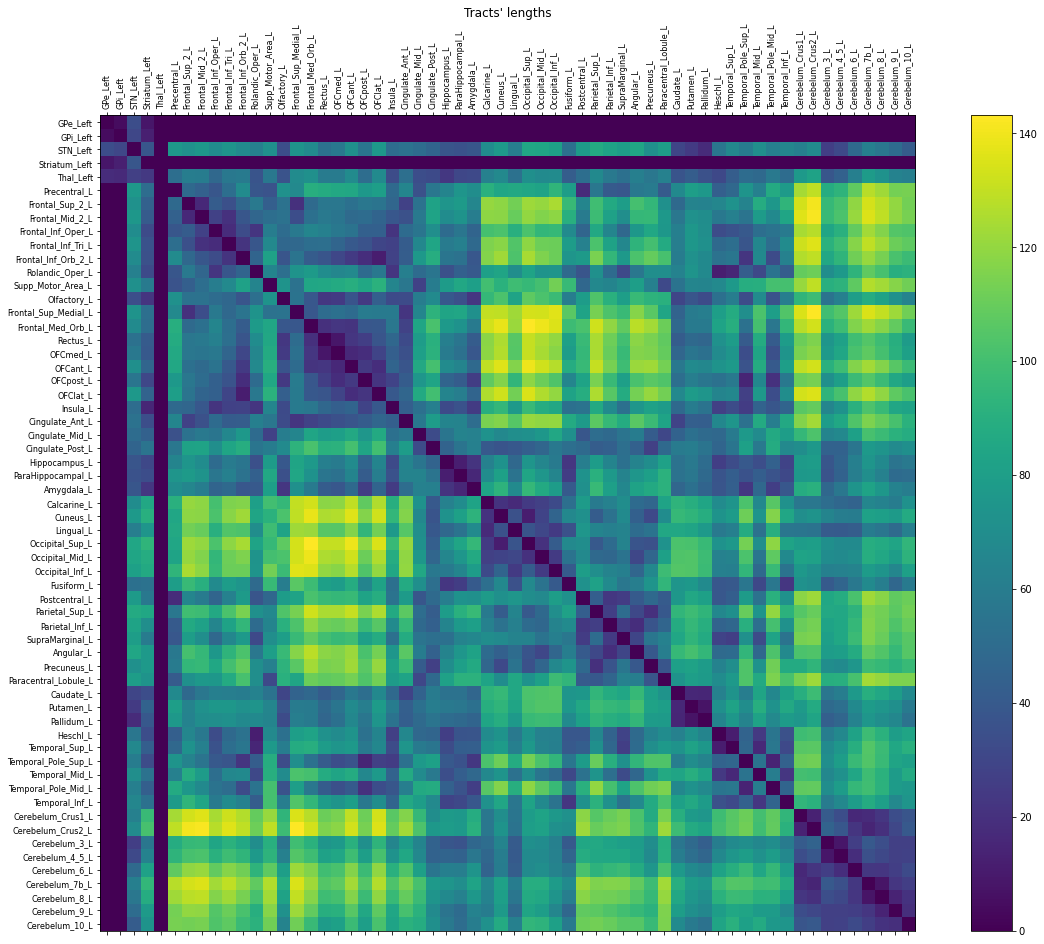

In [7]:
#white_matter_coupling = coupling.Linear(a=0.014)
# Create a TVB simulator and set all desired inputs
# (connectivity, model, surface, stimuli etc)
# We choose all defaults in this example
simulator = CoSimulator()
#simulator.use_numba = False
model_params = {}
simulator.model = ReducedWongWangExcIO(**model_params)

simulator.connectivity = connectivity

simulator.integrator = HeunStochastic()
simulator.integrator.dt = 0.1
simulator.integrator.noise.nsig = np.array([1e-6])

mon_raw = Raw(period=1.0)  # ms
simulator.monitors = (mon_raw, )

simulator.connectivity.set_idelays(simulator.integrator.dt)
simulator.horizon = simulator.connectivity.idelays.max() + 1

init_cond = np.load(os.path.join(outputs_path, "tvb_init_cond_left_noVermis.npy"))  # 
simulator.initial_conditions = init_cond * np.ones((simulator.horizon,
                                                    simulator.model.nvar,
                                                    simulator.connectivity.number_of_regions,
                                                    simulator.model.number_of_modes))


print("\nConnectome used for simulations:")
plotter.plot_tvb_connectivity(simulator.connectivity);


In [8]:
print(wTVB[29:34][:, 2])

[0. 0. 0. 0. 0.]


In [9]:
# Load full TVB connectome connectivity

conn_path = os.path.join(data_path, "basal_ganglia_conn")

#Load AAL atlas normative connectome including the Basal Ganglia regions from Petersen et al. atlas
wTVB = np.loadtxt(os.path.join(conn_path, "conn_denis_weights.txt"))
cTVB = np.loadtxt(os.path.join(conn_path, "aal_plus_BG_centers.txt"),usecols=range(1,3))
rlTVB = np.loadtxt(os.path.join(conn_path, "aal_plus_BG_centers.txt"),dtype="str", usecols=(0,))
tlTVB = np.loadtxt(os.path.join(conn_path, "BGplusAAL_tract_lengths.txt"))
print("Visual areas")
print(rlTVB[58:68])
print("STN")
print(rlTVB[[4, 5]])
print("Visual areas -> STN weights:")
print(wTVB[58:68][:, [4, 5]])
print("Visual areas -> STN lengths:")
print(tlTVB[58:68][:, [4, 5]])
# rlTVB[
#     np.argsort(
#         wTVB[58:68][:, rlTVB.tolist().index('Cuneus_L')])[::-1]]

Visual areas
['Cuneus_L' 'Cuneus_R' 'Lingual_L' 'Lingual_R' 'Occipital_Sup_L'
 'Occipital_Sup_R' 'Occipital_Mid_L' 'Occipital_Mid_R' 'Occipital_Inf_L'
 'Occipital_Inf_R']
STN
['STN_Left' 'STN_Right']
Visual areas -> STN weights:
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
Visual areas -> STN lengths:
[[77.44244151 78.60168775]
 [75.15551477 76.442058  ]
 [61.05470971 62.04064902]
 [54.67381409 55.98288226]
 [84.43525877 85.51634775]
 [78.70754139 80.02639237]
 [84.17883884 85.08876704]
 [76.42552135 77.78407252]
 [81.38344655 82.17246911]
 [74.39245207 75.71118817]]


## 2. Build and connect the ANNarchy network model <br> (networks of spiking neural populations for fine-scale <br>regions, stimulation devices, spike detectors etc)

In [10]:
from tvb_multiscale.tvb_annarchy.annarchy_models.builders.models.basal_ganglia_izhikevich import BasalGangliaIzhikevichBuilder
from tvb_multiscale.tvb_annarchy.annarchy.models import Izhikevich_Hamker

# Select the regions for the fine scale modeling with ANNarchy spiking networks
#including cortex node:
spiking_nodes_ids = [0, 1, 2, 3, 4]  # the indices of fine scale regions modeled with ANNarchy

# Build a ANNarchy network model with the corresponding builder
ann_model_builder = BasalGangliaIzhikevichBuilder(simulator, spiking_nodes_ids, config=config, set_defaults=False)



# Using all default parameters for this example
# ann_model_builder.set_defaults()

# or...

# # ----------------------------------------------------------------------------------------------------------------
# # ----Uncomment below to modify the builder by changing the default options:--------------------------------------
# # ----------------------------------------------------------------------------------------------------------------
from copy import deepcopy

population_neuron_model = Izhikevich_Hamker

ann_model_builder.population_order = 200 # reduce for speed

# When any of the properties model, params and scale below depends on regions,
# set a handle to a function with
# arguments (region_index=None) returning the corresponding property

ann_model_builder.params_common = \
    {"v": -70.0, "u": -18.55, "E_ampa": 0.0, "E_gaba": -90.0, "v_th": 30.0, "Vr": 0.0, "c": -65.0,
     "C": 1.0, "I": 0.0,
     "tau_syn": 1.0, "tau_ampa": 10.0, "tau_gaba": 10.0,
     "n0": 140.0, "n1": 5.0, "n2": 0.04}

ann_model_builder._paramsI = deepcopy(ann_model_builder.params_common)
ann_model_builder._paramsI.update({"a": 0.005, "b": 0.585, "d": 4.0})
ann_model_builder._paramsE = deepcopy(ann_model_builder.params_common)
ann_model_builder.paramsStr = deepcopy(ann_model_builder.params_common)
ann_model_builder.paramsStr.update({"v_th": 40.0, "C": 50.0, "Vr": -80.0,
                                    "n0": 61.65, "n1": 2.59, "n2": 0.02, 
                                    "a": 0.05, "b": -20.0, "c": -55.0, "d": 377.0})

ann_model_builder.Igpe_nodes_ids = [0]
ann_model_builder.Igpi_nodes_ids = [1]
ann_model_builder.Estn_nodes_ids = [2]
ann_model_builder.Eth_nodes_ids = [4]
ann_model_builder.Istr_nodes_ids = [3]


I_nodes_ids = ann_model_builder.Igpe_nodes_ids + ann_model_builder.Igpi_nodes_ids
E_nodes_ids = ann_model_builder.Estn_nodes_ids + ann_model_builder.Eth_nodes_ids


def paramsE_fun(node_id):
    paramsE = deepcopy(ann_model_builder._paramsE)
    if node_id in ann_model_builder.Estn_nodes_ids:
        paramsE.update({"a": 0.005, "b": 0.265, "d": 2.0, "I": 3.0})  # dictionary of params for Estn
    elif node_id in ann_model_builder.Eth_nodes_ids:
        paramsE.update({"a": 0.02, "b": 0.25, "d": 0.05, "I": 3.5})   # dictionary of params for Eth
    return paramsE
    
def paramsI_fun(node_id):
    # For the moment they are identical, unless you differentiate the noise parameters
    paramsI = deepcopy(ann_model_builder._paramsI)
    if node_id in ann_model_builder.Igpe_nodes_ids:
        paramsI.update({"I": 12.0})
    elif node_id in ann_model_builder.Igpi_nodes_ids:
        paramsI.update({"I": 30.0})
    return paramsI
    
# Populations' configurations
# When any of the properties model, params and scale below depends on regions,
# set a handle to a function with
# arguments (region_index=None) returning the corresponding property
ann_model_builder.populations = [
    {"label": "E", "model": population_neuron_model,  
     "params":  paramsE_fun, 
     "nodes": E_nodes_ids,  # Estn in [2], Eth in [4]
     "scale": 1.0},
    {"label": "I", "model": population_neuron_model,  
     "params": paramsI_fun, 
     "nodes": I_nodes_ids,  # Igpe in [0], Igpi in [1]
     "scale": 1.0},
    {"label": "IdSN", "model": population_neuron_model,   
     "params": ann_model_builder.paramsStr, 
     "nodes": ann_model_builder.Istr_nodes_ids,  # IdSN in [3]
     "scale": 1.0},
    {"label": "IiSN", "model": population_neuron_model,   # IiSN in [3]
     "params": ann_model_builder.paramsStr, 
     "nodes": ann_model_builder.Istr_nodes_ids,  # None means "all"
     "scale": 1.0}
]

# Within region-node connections
# When any of the properties model, conn_spec, weight, delay, receptor_type below
# set a handle to a function with
# arguments (region_index=None) returning the corresponding property

# NOTE!!! TAKE CARE OF DEFAULT simulator.coupling.a!
ann_model_builder.global_coupling_scaling = 1.0 # ann_model_builder.coupling_a 
# if we use Reduced Wong Wang model, we also need to multiply with the global coupling constant G:
# ann_model_builder.global_coupling_scaling *= ann_model_builder.G

synapse_model = "DefaultSpikingSynapse"
conn_spec = {'rule': "all_to_all", 
             "allow_self_connections": True, "force_multiple_weights": False}
conn_spec_fixed_probability = conn_spec.copy()
conn_spec_fixed_probability.update({'rule': "fixed_probability", "probability": 0.1})

def conn_spec_fixed_prob(prob=None):
    output = conn_spec_fixed_probability.copy()
    if prob is not None:
        output["probability"] = prob
    return output

within_node_delay = 1.0
        

# for each connection, we have a different probability
ann_model_builder.populations_connections = [
     #        source   ->   target
    {"source": "I", "target": "I",  # I -> I This is a self-connection for population "Igpe"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pGPeGPe),  # conn_spec
     "weight": np.abs(wGPeGPe), "delay": within_node_delay,
     "receptor_type": "gaba", "nodes": ann_model_builder.Igpe_nodes_ids},  # None means apply to all
    {"source": "I", "target": "I",  # I -> I This is a self-connection for population "Igpi"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pGPiGPi),  # conn_spec
     "weight": np.abs(wGPiGPi), "delay": within_node_delay,
     "receptor_type": "gaba", "nodes": ann_model_builder.Igpi_nodes_ids},  # None means apply to all
    {"source": "IdSN", "target": "IdSN",  # IdSN -> IdSN This is a self-connection for population "IdSN"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pdSNdSN),  # conn_spec
     "weight": np.abs(wdSNdSN), "delay": within_node_delay,
     "receptor_type": "gaba", "nodes": ann_model_builder.Istr_nodes_ids},
    {"source": "IiSN", "target": "IiSN",  # IiSN -> IiSN This is a self-connection for population "IiSN"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(piSNiSN),  # conn_spec
     "weight": np.abs(wiSNiSN), "delay": within_node_delay,
     "receptor_type": "gaba", "nodes": ann_model_builder.Istr_nodes_ids}
    ]


# Among/Between region-node connections
# Given that only the AMPA population of one region-node couples to
# all populations of another region-node,
# we need only one connection type
        
# When any of the properties model, conn_spec, weight, delay, receptor_type below
# depends on regions, set a handle to a function with
# arguments (source_region_index=None, target_region_index=None)

from tvb_multiscale.core.spiking_models.builders.templates import scale_tvb_weight, tvb_delay
        
class TVBWeightFun(object):
    tvb_weights = ann_model_builder.tvb_weights
    global_coupling_scaling = ann_model_builder.global_coupling_scaling
    
    def __init__(self, scale=ann_model_builder.global_coupling_scaling):
        self.tvb_weights = ann_model_builder.tvb_weights
        self.global_coupling_scaling = ann_model_builder.global_coupling_scaling
        
    def __call__(self, source_node, target_node):
        return scale_tvb_weight(source_node, target_node, self.tvb_weights,
                                scale=self.global_coupling_scaling)
    
tvb_delay_fun = \
    lambda source_node, target_node: \
        np.maximum(ann_model_builder.tvb_dt, tvb_delay(source_node, target_node, ann_model_builder.tvb_delays))

# Total excitatory spikes of one region node will be distributed to
ann_model_builder.nodes_connections = [
    #        source    ->     target
    {"source": "IdSN", "target": "I",             # "IdSN" -> "Igpi"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pdSNGPi),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "gaba", 
     "source_nodes": ann_model_builder.Istr_nodes_ids, 
     "target_nodes": ann_model_builder.Igpi_nodes_ids},  # None means apply to all
    {"source": "IiSN", "target": "I",            # "IiSN" -> "Igpe"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(piSNGPe),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "gaba", 
     "source_nodes": ann_model_builder.Istr_nodes_ids, 
     "target_nodes": ann_model_builder.Igpe_nodes_ids},  # None means apply to all
    {"source": "I", "target": "I",             # "Igpe" -> "Igpi"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pGPeGPi),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "gaba", 
     "source_nodes": ann_model_builder.Igpe_nodes_ids, 
     "target_nodes": ann_model_builder.Igpi_nodes_ids},  # None means apply to all
    {"source": "I", "target": "E",              # "Igpi" -> "Eth"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pGPiTh),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "gaba", 
     "source_nodes": ann_model_builder.Igpi_nodes_ids, 
     "target_nodes": ann_model_builder.Eth_nodes_ids},  # None means apply to all
    {"source": "I", "target": "E",             # "Igpe" -> "Estn"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pGPeSTN),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "gaba", 
     "source_nodes": ann_model_builder.Igpe_nodes_ids, 
     "target_nodes": ann_model_builder.Estn_nodes_ids},  # None means apply to all
    {"source": "E", "target": "IdSN",   # "Eth" -> ["IdSN"] 
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pThdSN),  # conn_spec
     "weight": TVBWeightFun(), # wThdSN, # 
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "ampa", 
     "source_nodes": ann_model_builder.Eth_nodes_ids, 
     "target_nodes": ann_model_builder.Istr_nodes_ids},  # None means apply to all
    {"source": "E", "target": "IiSN",   # "Eth" -> ["IiSN"] 
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pThiSN),  # conn_spec
     "weight": wThiSN,
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "ampa", 
     "source_nodes": ann_model_builder.Eth_nodes_ids, 
     "target_nodes": ann_model_builder.Istr_nodes_ids},  # No
     {"source": "E", "target": "I",          # "Estn" -> ["Igpe"]
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pSTNGPe),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "ampa", 
     "source_nodes": ann_model_builder.Estn_nodes_ids, 
     "target_nodes": ann_model_builder.Igpe_nodes_ids},
    {"source": "E", "target": "I",          # "Estn" -> ["Igpi"]
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pSTNGPi),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "ampa", 
     "source_nodes": ann_model_builder.Estn_nodes_ids, 
     "target_nodes": ann_model_builder.Igpi_nodes_ids}
     ]

# Creating  devices to be able to observe ANNarchy activity:

ann_model_builder.output_devices = []

period = 1.0

# Creating  devices to be able to observe ANNarchy activity:
params = deepcopy(ann_model_builder.config.ANNARCHY_OUTPUT_DEVICES_PARAMS_DEF["SpikeMonitor"])
params["period"] = period
for pop in ann_model_builder.populations:
    connections = OrderedDict({})
    #                      label <- target population
    params["label"] = pop["label"] + "_spikes"
    connections[params["label"]] = pop["label"]
    ann_model_builder.output_devices.append(
        {"model": "SpikeMonitor", "params": deepcopy(params),
         "connections": connections, "nodes": pop["nodes"]})  # None means apply to "all"

# Labels have to be different for every connection to every distinct population
# params for baladron implementation commented out for the moment
# TODO: use baladron neurons
params = deepcopy(ann_model_builder.config.ANNARCHY_OUTPUT_DEVICES_PARAMS_DEF["Monitor"])
params.update({"period": period,  'record_from': ["v", "u", "I_syn", "I_syn_ex", "I_syn_in", "g_ampa", "g_gaba", "g_base"]})
for pop in ann_model_builder.populations:
    connections = OrderedDict({})
    #               label    <- target population
    connections[pop["label"]] = pop["label"]
    params["label"] = pop["label"]
    ann_model_builder.output_devices.append(
        {"model": "Monitor", "params": deepcopy(params),
         "connections": connections, "nodes": pop["nodes"]})  # None means apply to all
    
    
# # Create a spike stimulus input device
# # including cortex node: we do not need any other external stimulation
# ann_model_builder.Estn_stim = {"rate": 500.0, "weight": 0.009}
# ann_model_builder.Igpe_stim = {"rate": 100.0, "weight": 0.015}
# ann_model_builder.Igpi_stim = {"rate": 700.0, "weight": 0.02}
ann_model_builder.input_devices = [
#             {"model": "PoissonPopulation",
#              "params": {"rates": ann_model_builder.Estn_stim["rate"], 
#                         "geometry": int(np.round(ann_model_builder.populations[0]["scale"](ann_model_builder.Estn_nodes_ids) * 
#                                                  ann_model_builder.population_order)), 
#                         "name": "BaselineEstn"},
#              "connections": {"BaselineEstn": ["E"]},  # "Estn"
#              "nodes": ann_model_builder.Estn_nodes_ids,  # None means apply to all
#              "weights": ann_model_builder.Estn_stim["weight"], "delays": 0.0, "receptor_type": "ampa"},
#             {"model": "PoissonPopulation",
#              "params": {"rates": ann_model_builder.Igpe_stim["rate"], 
#                         "geometry": int(np.round(ann_model_builder.populations[1]["scale"](ann_model_builder.Igpe_nodes_ids) * 
#                                                  ann_model_builder.population_order)), 
#                         "name": "BaselineIgpe"},
#              "connections": {"BaselineIgpe": ["I"]},  # "Igpe"
#              "nodes": ann_model_builder.Igpe_nodes_ids,  # None means apply to all
#              "weights": ann_model_builder.Igpe_stim["weight"], "delays": 0.0, "receptor_type": "ampa"},
#             {"model": "PoissonPopulation",
#              "params": {"rates": ann_model_builder.Igpi_stim["rate"], 
#                         "geometry": int(np.round(ann_model_builder.populations[1]["scale"](ann_model_builder.Igpi_nodes_ids) * 
#                                                  ann_model_builder.population_order)), 
#                         "name": "BaselineIgpi"},
#              "connections": {"BaselineIgpi": ["I"]},  # "Igpi"
#              "nodes": ann_model_builder.Igpi_nodes_ids,  # None means apply to all
#              "weights": ann_model_builder.Igpi_stim["weight"], "delays": 0.0, "receptor_type": "ampa"},
       ]  #

# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------


annarchy_network = ann_model_builder.build_spiking_network()


ANNarchy 4.6 (4.6.9.7) on linux (posix). 
2021-03-01 15:07:47,738 - INFO - tvb_multiscale.tvb_annarchy.annarchy_models.builders.base - Loading an ANNarchy instance...
2021-03-01 15:07:47,738 - INFO - tvb_multiscale.tvb_annarchy.annarchy_models.builders.base - Loading an ANNarchy instance...
2021-03-01 15:07:47,744 - INFO - tvb_multiscale.tvb_annarchy.annarchy_models.builders.base - Cleaning ANNarchy compilation directory, if any...
2021-03-01 15:07:47,744 - INFO - tvb_multiscale.tvb_annarchy.annarchy_models.builders.base - Cleaning ANNarchy compilation directory, if any...
2021-03-01 15:07:48,950 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model SpikeMonitor for E_spikes created!
2021-03-01 15:07:48,950 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model SpikeMonitor for E_spikes created!
2021-03-01 15:07:48,964 - INFO - tvb_multiscale.co

In [11]:
populations_sizes = []
print("Population sizes: ")
for pop in ann_model_builder.populations:
    populations_sizes.append(int(np.round(pop["scale"] * ann_model_builder.population_order)))
    print("%s: %d" % (pop["label"], populations_sizes[-1]))
    

Population sizes: 
E: 200
I: 200
IdSN: 200
IiSN: 200


In [12]:
# print(nest_network.print_str(connectivity=True))
print("Within node's connections:")
for pop in ann_model_builder.populations_connections:
    if hasattr(pop["weight"], "__call__"):
        weight = pop["weight"](pop["nodes"])
    else:
        weight = pop["weight"]
    try:
        p = pop["conn_spec"]["probability"]
    except:
        p = 1.0
    w_conn = assert_loadedParams[np.abs(weight)]
    conn = w_conn.split("_weights")[0]
    p_conn = loadedParams["%s_probs" % conn]
    w_conn = loadedParams[w_conn]
    print("%s -> %s (%s) = %g (p=%g): %s (%g, %g)" 
          % (pop["source"], pop["target"], pop["receptor_type"], weight, p,
             conn, w_conn, p_conn))
    
print("\nAmong node's connections:")
for pop in ann_model_builder.nodes_connections:
    if hasattr(pop["weight"], "__call__"):
        weight = pop["weight"](pop["source_nodes"], pop["target_nodes"]).item()
    else:
        weight = pop["weight"]
    try:
        p = pop["conn_spec"]["probability"]
    except:
        p = 1.0
    w_conn = assert_loadedParams[np.abs(weight)]
    conn = w_conn.split("_weights")[0]
    p_conn = loadedParams["%s_probs" % conn]
    w_conn = loadedParams[w_conn]
    print("%s -> %s (%s) = %g (p=%g): %s (%g, %g)" 
          % (pop["source"], pop["target"], pop["receptor_type"], weight, p,
             conn, w_conn, p_conn))

Within node's connections:
I -> I (gaba) = 0.00773167 (p=0.323896): GPeGPe (0.00773167, 0.323896)
I -> I (gaba) = 0.0119856 (p=0.317476): GPiGPi (0.0119856, 0.317476)
IdSN -> IdSN (gaba) = 0.0081135 (p=0.44881): dSNdSN (0.0081135, 0.44881)
IiSN -> IiSN (gaba) = 0.0139626 (p=0.204922): iSNiSN (0.0139626, 0.204922)

Among node's connections:
IdSN -> I (gaba) = 0.00913217 (p=0.170292): dSNGPi (0.00913217, 0.170292)
IiSN -> I (gaba) = 0.00766353 (p=0.407464): iSNGPe (0.00766353, 0.407464)
I -> I (gaba) = 0.0062383 (p=0.323173): GPeGPi (0.0062383, 0.323173)
I -> E (gaba) = 0.00665013 (p=0.259374): GPiThal (0.00665013, 0.259374)
I -> E (gaba) = 0.00676034 (p=0.184785): GPeSTN (0.00676034, 0.184785)
E -> IdSN (ampa) = 0.0122845 (p=0.127913): ThaldSN (0.0122845, 0.127913)
E -> IiSN (ampa) = 0.00698403 (p=0.175348): ThaliSN (0.00698403, 0.175348)
E -> I (ampa) = 0.0107546 (p=0.411954): STNGPe (0.0107546, 0.411954)
E -> I (ampa) = 0.0135662 (p=0.245841): STNGPi (0.0135662, 0.245841)


## 3. Build the TVB-ANNarchy interface

In [13]:
from tvb_multiscale.tvb_annarchy.interfaces.builders.models.red_ww_basal_ganglia_izhikevich import RedWWexcIOBuilder

    
# Build a TVB-ANNarchy interface with all the appropriate connections between the
# TVB and ANNarchy modelled regions
tvb_annarchy_builder = \
    RedWWexcIOBuilder(simulator, annarchy_network, spiking_nodes_ids, 
                      exclusive_nodes=True, populations_sizes=populations_sizes)

tvb_to_annarchy_mode = "rate"
annarchy_to_tvb = True

# Using all default parameters for this example

# or...


# ----------------------------------------------------------------------------------------------------------------
# ----Uncomment below to modify the builder by changing the default options:--------------------------------------
# ----------------------------------------------------------------------------------------------------------------


# TVB -> ANNarchy


# --------For spike transmission from TVB to ANNarchy devices acting as TVB proxy nodes with TVB delays:--------

# tvb_annarchy_builder.G = tvb_annarchy_builder.tvb_simulator.model.G[0].item()
# tvb_annarchy_builder.global_coupling_scaling = tvb_annarchy_builder.tvb_simulator.coupling.a[0].item() * tvb_annarchy_builder.G
tvb_annarchy_builder.global_coupling_scaling = 1.0

tvb_delay_fun = \
    lambda source_node, target_node: \
        np.maximum(tvb_annarchy_builder.tvb_dt, tvb_delay(source_node, target_node, tvb_annarchy_builder.tvb_delays))

tvb_annarchy_builder.tvb_to_spikeNet_interfaces = []
if tvb_to_annarchy_mode == "rate":
    # Mean spike rates are applied in parallel to all target neurons
    for trg_pop, target_nodes, this_conn_spec in zip(["IdSN", "IiSN", "E"],
                                                     [ann_model_builder.Istr_nodes_ids, 
                                                      ann_model_builder.Istr_nodes_ids,
                                                      ann_model_builder.Estn_nodes_ids],  
                                                     [conn_spec_fixed_prob(prob=pCtxdSN), # pCtxdSN
                                                      conn_spec_fixed_prob(prob=pCtxiSN), # pCtxiSN
                                                      conn_spec_fixed_prob(prob=pCtxSTN)]): # pCtxSTN           
        tvb_annarchy_builder.tvb_to_spikeNet_interfaces.append(
            {"model": "TimedArrayPoissonPopulation", "params": {"geometry": 600},
        # ---------Properties potentially set as function handles with args (tvb_node_id=None)-------------------------
             "interface_weights": 0.5,
        # Applied outside ANNarchy for each interface device
        # -------Properties potentially set as function handles with args (tvb_node_id=None, annarchy_node_id=None)-----------
             "weights": TVBWeightFun(scale=tvb_annarchy_builder.global_coupling_scaling),
             "delays": lambda tvb_node_id, annarchy_node_id: tvb_delay_fun(tvb_node_id, annarchy_node_id),
             "receptor_type": "ampa",
             "conn_spec": this_conn_spec,
        # --------------------------------------------------------------------------------------------------------------
        #             TVB sv -> ANNarchy population
             "connections": {"R": trg_pop},
             "source_nodes": None, "target_nodes": target_nodes})  # None means all here

    
if annarchy_to_tvb:
    tvb_annarchy_builder.spikeNet_to_tvb_interfaces = []
    # TVB <-- ANNarchy:
    for src_pop, nodes in zip(["I",         "E",         ["IdSN", "IiSN"]],
                              [I_nodes_ids, E_nodes_ids, ann_model_builder.Istr_nodes_ids]):
        #            TVB <- ANNarchy
        tvb_annarchy_builder.spikeNet_to_tvb_interfaces.append(
            {"model": "SpikeMonitor", "params": {},
        # ------------------Properties potentially set as function handles with args (annarchy_node_id=None)--------------------
             "interface_weights": 1.0, "delays": 0.0,
        # -----------------------------------------------------------------------------------------------------------------                 #            TVB <- ANNarchy
        #                    TVB <- ANNarchy
             "connections": {"Rin": src_pop}, "nodes": nodes})  # None means all here
    
tvb_annarchy_builder.w_tvb_to_spike_rate = 1.0
# We return from a ANNarchy SpikeMonitor the ratio number_of_population_spikes / number_of_population_neurons
# for every TVB time step, which is already a quantity in the range [0.0, 1.0],
# as long as a neuron cannot fire twice during a TVB time step, i.e.,
# as long as the TVB time step (usually 0.001 to 0.1 ms)
# is smaller than the neurons' refractory time, t_ref (usually 1-2 ms)
tvb_annarchy_builder.w_spikes_to_tvb = 1000.0

# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------

tvb_annarchy_model = tvb_annarchy_builder.build_interface(tvb_to_annarchy_mode=tvb_to_annarchy_mode, annarchy_to_tvb=annarchy_to_tvb)


2021-03-01 15:07:50,713 - INFO - tvb_multiscale.core.interfaces.base - <class 'tvb_multiscale.tvb_annarchy.interfaces.models.RedWWexcIO'> created!
2021-03-01 15:07:50,713 - INFO - tvb_multiscale.core.interfaces.base - <class 'tvb_multiscale.tvb_annarchy.interfaces.models.RedWWexcIO'> created!
2021-03-01 15:07:50,718 - INFO - tvb_multiscale.tvb_annarchy.interfaces.models - <class 'tvb_multiscale.tvb_annarchy.interfaces.models.RedWWexcIO'> created!
2021-03-01 15:07:50,718 - INFO - tvb_multiscale.tvb_annarchy.interfaces.models - <class 'tvb_multiscale.tvb_annarchy.interfaces.models.RedWWexcIO'> created!
2021-03-01 15:07:50,734 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model TimedArrayPoissonPopulation for R created!
2021-03-01 15:07:50,734 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model TimedArrayPoissonPopulation for R created!
2021-0

## 3. Configure simulator, simulate, gather results

In [14]:
# -----------------------------------4. Compile network ---------------------------------------------------------
# Compile the ANNarchy network...
tic_compile = time.time()
annarchy_network.configure()
print("Compiled! in %f min" % ((time.time() - tic_compile) / 60))
print(annarchy_network.print_str(connectivity=True))
print(tvb_annarchy_model.print_str(detailed_output=True, connectivity=False))


Compiling... 
OK 
Compiled! in 5.531923 min

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
ANNarchyNetwork:

----------------------------------------------------------------------------------------------------

SpikingBrain - Regions: ['GPe_Left', 'GPi_Left', 'STN_Left', 'Striatum_Left', 'Thal_Left']
Regions' nodes:


----------------------------------------------------------------------------------------------------
ANNarchyRegionNode - Label: GPe_Left
Populations ['I']:

----------------------------------------------------------------------------------------------------

ANNarchyPopulation - Label: I 
model: Spiking neuron
200 neurons in population with index: 0
parameters: {'a': array([0.005]), 'b': array([0.585]), 'c': array([-

In [15]:
 # -----------------------------------5. Simulate and gather results-------------------------------------------------
simulation_length = 220.0
transient = 20.0 # simulation_length/11
# ...and simulate!
t_start = time.time()
simulator.configure(tvb_annarchy_model)

if simulation_mode == "rs":
    simulation_length1 = simulation_length
else:
    simulation_length1 = 35.0
    
results = simulator.run(simulation_length=simulation_length1, # 35.0 with stimulus application
                        configure_spiking_simulator=False)    # because compilation has already be done

if simulation_mode != "rs":
    # for stimulus application:
    Istim = -200.0
    annarchy_network.brain_regions["GPi_Left"]["I"].Set(
        {"I": Istim + annarchy_network.brain_regions["GPi_Left"]["I"].Get("I")["I"]})
    results2 = simulator.run(simulation_length=50.0, 
                             configure_spiking_simulator=False)  # because compilation has already be done
    annarchy_network.brain_regions["GPi_Left"]["I"].Set(
        {"I": annarchy_network.brain_regions["GPi_Left"]["I"].Get("I")["I"] - Istim})
    results3 = simulator.run(simulation_length=25.0, 
                             configure_spiking_simulator=False)  # because compilation has already be done
    results[0] = list(results[0])
    results[0][0] = np.concatenate([results[0][0], results2[0][0], results3[0][0]], axis=0)
    results[0][1] = np.concatenate([results[0][1], results2[0][1], results3[0][1]], axis=0)

print("\nSimulated in %f secs!" % (time.time() - t_start))

Simulating 0.0001 seconds of the network took 0.0021398067474365234 seconds. 
Simulating 0.0001 seconds of the network took 0.002880096435546875 seconds. 
Simulating 0.0001 seconds of the network took 0.003107786178588867 seconds. 
Simulating 0.0001 seconds of the network took 0.0027108192443847656 seconds. 
Simulating 0.0001 seconds of the network took 0.002325296401977539 seconds. 
Simulating 0.0001 seconds of the network took 0.0025696754455566406 seconds. 
Simulating 0.0001 seconds of the network took 0.0017142295837402344 seconds. 
Simulating 0.0001 seconds of the network took 0.0034449100494384766 seconds. 
Simulating 0.0001 seconds of the network took 0.002525806427001953 seconds. 
Simulating 0.0001 seconds of the network took 0.002207040786743164 seconds. 
Simulating 0.0001 seconds of the network took 0.0024614334106445312 seconds. 
Simulating 0.0001 seconds of the network took 0.0021545886993408203 seconds. 
Simulating 0.0001 seconds of the network took 0.0021555423736572266 s

Simulating 0.0001 seconds of the network took 0.002310514450073242 seconds. 
Simulating 0.0001 seconds of the network took 0.0023598670959472656 seconds. 
Simulating 0.0001 seconds of the network took 0.0021829605102539062 seconds. 
Simulating 0.0001 seconds of the network took 0.001990795135498047 seconds. 
Simulating 0.0001 seconds of the network took 0.0018470287322998047 seconds. 
Simulating 0.0001 seconds of the network took 0.0023584365844726562 seconds. 
Simulating 0.0001 seconds of the network took 0.0018281936645507812 seconds. 
Simulating 0.0001 seconds of the network took 0.0017268657684326172 seconds. 
Simulating 0.0001 seconds of the network took 0.0017244815826416016 seconds. 
Simulating 0.0001 seconds of the network took 0.0022966861724853516 seconds. 
Simulating 0.0001 seconds of the network took 0.002384185791015625 seconds. 
Simulating 0.0001 seconds of the network took 0.0020127296447753906 seconds. 
Simulating 0.0001 seconds of the network took 0.0017092227935791016

Simulating 0.0001 seconds of the network took 0.0019774436950683594 seconds. 
Simulating 0.0001 seconds of the network took 0.0023360252380371094 seconds. 
Simulating 0.0001 seconds of the network took 0.001962900161743164 seconds. 
Simulating 0.0001 seconds of the network took 0.0021092891693115234 seconds. 
Simulating 0.0001 seconds of the network took 0.0017473697662353516 seconds. 
Simulating 0.0001 seconds of the network took 0.0016601085662841797 seconds. 
Simulating 0.0001 seconds of the network took 0.001725912094116211 seconds. 
Simulating 0.0001 seconds of the network took 0.001728057861328125 seconds. 
...10.0% done in 5.6 sec
Simulating 0.0001 seconds of the network took 0.001951456069946289 seconds. 
Simulating 0.0001 seconds of the network took 0.0018548965454101562 seconds. 
Simulating 0.0001 seconds of the network took 0.002357006072998047 seconds. 
Simulating 0.0001 seconds of the network took 0.0021066665649414062 seconds. 
Simulating 0.0001 seconds of the network too

Simulating 0.0001 seconds of the network took 0.001939535140991211 seconds. 
Simulating 0.0001 seconds of the network took 0.0018913745880126953 seconds. 
Simulating 0.0001 seconds of the network took 0.0019230842590332031 seconds. 
Simulating 0.0001 seconds of the network took 0.0018329620361328125 seconds. 
Simulating 0.0001 seconds of the network took 0.001641988754272461 seconds. 
Simulating 0.0001 seconds of the network took 0.002043485641479492 seconds. 
Simulating 0.0001 seconds of the network took 0.001684427261352539 seconds. 
Simulating 0.0001 seconds of the network took 0.0019752979278564453 seconds. 
Simulating 0.0001 seconds of the network took 0.0015606880187988281 seconds. 
Simulating 0.0001 seconds of the network took 0.0018389225006103516 seconds. 
Simulating 0.0001 seconds of the network took 0.0021321773529052734 seconds. 
Simulating 0.0001 seconds of the network took 0.0018689632415771484 seconds. 
Simulating 0.0001 seconds of the network took 0.0017325878143310547 

Simulating 0.0001 seconds of the network took 0.0023190975189208984 seconds. 
Simulating 0.0001 seconds of the network took 0.002521991729736328 seconds. 
Simulating 0.0001 seconds of the network took 0.0022284984588623047 seconds. 
Simulating 0.0001 seconds of the network took 0.002790212631225586 seconds. 
Simulating 0.0001 seconds of the network took 0.0015978813171386719 seconds. 
Simulating 0.0001 seconds of the network took 0.0016186237335205078 seconds. 
Simulating 0.0001 seconds of the network took 0.0017440319061279297 seconds. 
Simulating 0.0001 seconds of the network took 0.0022144317626953125 seconds. 
Simulating 0.0001 seconds of the network took 0.002367734909057617 seconds. 
...20.0% done in 10.9 sec
Simulating 0.0001 seconds of the network took 0.0022590160369873047 seconds. 
Simulating 0.0001 seconds of the network took 0.0023870468139648438 seconds. 
Simulating 0.0001 seconds of the network took 0.0022296905517578125 seconds. 
Simulating 0.0001 seconds of the network 

Simulating 0.0001 seconds of the network took 0.002578258514404297 seconds. 
Simulating 0.0001 seconds of the network took 0.0029981136322021484 seconds. 
Simulating 0.0001 seconds of the network took 0.0025064945220947266 seconds. 
Simulating 0.0001 seconds of the network took 0.002512693405151367 seconds. 
Simulating 0.0001 seconds of the network took 0.0025222301483154297 seconds. 
Simulating 0.0001 seconds of the network took 0.0023453235626220703 seconds. 
Simulating 0.0001 seconds of the network took 0.002470731735229492 seconds. 
Simulating 0.0001 seconds of the network took 0.002565145492553711 seconds. 
Simulating 0.0001 seconds of the network took 0.002614259719848633 seconds. 
Simulating 0.0001 seconds of the network took 0.0023682117462158203 seconds. 
Simulating 0.0001 seconds of the network took 0.0024404525756835938 seconds. 
Simulating 0.0001 seconds of the network took 0.0024232864379882812 seconds. 
Simulating 0.0001 seconds of the network took 0.0024819374084472656 s

Simulating 0.0001 seconds of the network took 0.002213716506958008 seconds. 
Simulating 0.0001 seconds of the network took 0.0023648738861083984 seconds. 
Simulating 0.0001 seconds of the network took 0.002269744873046875 seconds. 
Simulating 0.0001 seconds of the network took 0.0021996498107910156 seconds. 
Simulating 0.0001 seconds of the network took 0.0027990341186523438 seconds. 
Simulating 0.0001 seconds of the network took 0.002868175506591797 seconds. 
Simulating 0.0001 seconds of the network took 0.0029265880584716797 seconds. 
Simulating 0.0001 seconds of the network took 0.002930164337158203 seconds. 
...30.0% done in 17.3 sec
Simulating 0.0001 seconds of the network took 0.0030393600463867188 seconds. 
Simulating 0.0001 seconds of the network took 0.0024971961975097656 seconds. 
Simulating 0.0001 seconds of the network took 0.00260162353515625 seconds. 
Simulating 0.0001 seconds of the network took 0.0026063919067382812 seconds. 
Simulating 0.0001 seconds of the network too

Simulating 0.0001 seconds of the network took 0.0022487640380859375 seconds. 
Simulating 0.0001 seconds of the network took 0.002193450927734375 seconds. 
Simulating 0.0001 seconds of the network took 0.002233743667602539 seconds. 
Simulating 0.0001 seconds of the network took 0.0023136138916015625 seconds. 
Simulating 0.0001 seconds of the network took 0.002143383026123047 seconds. 
Simulating 0.0001 seconds of the network took 0.002156972885131836 seconds. 
Simulating 0.0001 seconds of the network took 0.0021562576293945312 seconds. 
Simulating 0.0001 seconds of the network took 0.00220489501953125 seconds. 
Simulating 0.0001 seconds of the network took 0.002351999282836914 seconds. 
Simulating 0.0001 seconds of the network took 0.0023193359375 seconds. 
Simulating 0.0001 seconds of the network took 0.002186298370361328 seconds. 
Simulating 0.0001 seconds of the network took 0.002130746841430664 seconds. 
Simulating 0.0001 seconds of the network took 0.0021202564239501953 seconds. 
S

Simulating 0.0001 seconds of the network took 0.001753091812133789 seconds. 
Simulating 0.0001 seconds of the network took 0.0017483234405517578 seconds. 
Simulating 0.0001 seconds of the network took 0.0021893978118896484 seconds. 
Simulating 0.0001 seconds of the network took 0.0016396045684814453 seconds. 
Simulating 0.0001 seconds of the network took 0.0015287399291992188 seconds. 
Simulating 0.0001 seconds of the network took 0.0016160011291503906 seconds. 
...40.0% done in 23.1 sec
Simulating 0.0001 seconds of the network took 0.0016751289367675781 seconds. 
Simulating 0.0001 seconds of the network took 0.0015540122985839844 seconds. 
Simulating 0.0001 seconds of the network took 0.0015454292297363281 seconds. 
Simulating 0.0001 seconds of the network took 0.0015604496002197266 seconds. 
Simulating 0.0001 seconds of the network took 0.0015723705291748047 seconds. 
Simulating 0.0001 seconds of the network took 0.0017833709716796875 seconds. 
Simulating 0.0001 seconds of the networ

Simulating 0.0001 seconds of the network took 0.002314329147338867 seconds. 
Simulating 0.0001 seconds of the network took 0.002361774444580078 seconds. 
Simulating 0.0001 seconds of the network took 0.0022704601287841797 seconds. 
Simulating 0.0001 seconds of the network took 0.002129793167114258 seconds. 
Simulating 0.0001 seconds of the network took 0.0022764205932617188 seconds. 
Simulating 0.0001 seconds of the network took 0.002313375473022461 seconds. 
Simulating 0.0001 seconds of the network took 0.0020012855529785156 seconds. 
Simulating 0.0001 seconds of the network took 0.0015964508056640625 seconds. 
Simulating 0.0001 seconds of the network took 0.0016567707061767578 seconds. 
Simulating 0.0001 seconds of the network took 0.002306699752807617 seconds. 
Simulating 0.0001 seconds of the network took 0.0017251968383789062 seconds. 
Simulating 0.0001 seconds of the network took 0.0016176700592041016 seconds. 
Simulating 0.0001 seconds of the network took 0.0016274452209472656 s

Simulating 0.0001 seconds of the network took 0.0019147396087646484 seconds. 
Simulating 0.0001 seconds of the network took 0.0022008419036865234 seconds. 
Simulating 0.0001 seconds of the network took 0.0019283294677734375 seconds. 
...50.0% done in 28.6 sec
Simulating 0.0001 seconds of the network took 0.0018148422241210938 seconds. 
Simulating 0.0001 seconds of the network took 0.0029489994049072266 seconds. 
Simulating 0.0001 seconds of the network took 0.0025811195373535156 seconds. 
Simulating 0.0001 seconds of the network took 0.0022389888763427734 seconds. 
Simulating 0.0001 seconds of the network took 0.002196073532104492 seconds. 
Simulating 0.0001 seconds of the network took 0.0024001598358154297 seconds. 
Simulating 0.0001 seconds of the network took 0.002305269241333008 seconds. 
Simulating 0.0001 seconds of the network took 0.0021834373474121094 seconds. 
Simulating 0.0001 seconds of the network took 0.0024051666259765625 seconds. 
Simulating 0.0001 seconds of the network

Simulating 0.0001 seconds of the network took 0.0023546218872070312 seconds. 
Simulating 0.0001 seconds of the network took 0.0021915435791015625 seconds. 
Simulating 0.0001 seconds of the network took 0.0018148422241210938 seconds. 
Simulating 0.0001 seconds of the network took 0.0018799304962158203 seconds. 
Simulating 0.0001 seconds of the network took 0.0016884803771972656 seconds. 
Simulating 0.0001 seconds of the network took 0.001901388168334961 seconds. 
Simulating 0.0001 seconds of the network took 0.002048492431640625 seconds. 
Simulating 0.0001 seconds of the network took 0.001722097396850586 seconds. 
Simulating 0.0001 seconds of the network took 0.0017361640930175781 seconds. 
Simulating 0.0001 seconds of the network took 0.0021135807037353516 seconds. 
Simulating 0.0001 seconds of the network took 0.0017879009246826172 seconds. 
Simulating 0.0001 seconds of the network took 0.0018122196197509766 seconds. 
Simulating 0.0001 seconds of the network took 0.0020868778228759766

Simulating 0.0001 seconds of the network took 0.003198385238647461 seconds. 
Simulating 0.0001 seconds of the network took 0.00304412841796875 seconds. 
Simulating 0.0001 seconds of the network took 0.0025932788848876953 seconds. 
Simulating 0.0001 seconds of the network took 0.002557516098022461 seconds. 
Simulating 0.0001 seconds of the network took 0.0022945404052734375 seconds. 
Simulating 0.0001 seconds of the network took 0.0020024776458740234 seconds. 
Simulating 0.0001 seconds of the network took 0.0018200874328613281 seconds. 
...60.0% done in 34.6 sec
Simulating 0.0001 seconds of the network took 0.00191497802734375 seconds. 
Simulating 0.0001 seconds of the network took 0.002199888229370117 seconds. 
Simulating 0.0001 seconds of the network took 0.0021331310272216797 seconds. 
Simulating 0.0001 seconds of the network took 0.001745462417602539 seconds. 
Simulating 0.0001 seconds of the network took 0.0017685890197753906 seconds. 
Simulating 0.0001 seconds of the network took 

Simulating 0.0001 seconds of the network took 0.003383159637451172 seconds. 
Simulating 0.0001 seconds of the network took 0.002671480178833008 seconds. 
Simulating 0.0001 seconds of the network took 0.002737283706665039 seconds. 
Simulating 0.0001 seconds of the network took 0.002679586410522461 seconds. 
Simulating 0.0001 seconds of the network took 0.002535104751586914 seconds. 
Simulating 0.0001 seconds of the network took 0.0026540756225585938 seconds. 
Simulating 0.0001 seconds of the network took 0.002490997314453125 seconds. 
Simulating 0.0001 seconds of the network took 0.0025243759155273438 seconds. 
Simulating 0.0001 seconds of the network took 0.0025949478149414062 seconds. 
Simulating 0.0001 seconds of the network took 0.002785921096801758 seconds. 
Simulating 0.0001 seconds of the network took 0.0026760101318359375 seconds. 
Simulating 0.0001 seconds of the network took 0.002908468246459961 seconds. 
Simulating 0.0001 seconds of the network took 0.002722024917602539 secon

Simulating 0.0001 seconds of the network took 0.002658367156982422 seconds. 
Simulating 0.0001 seconds of the network took 0.002360820770263672 seconds. 
Simulating 0.0001 seconds of the network took 0.002616405487060547 seconds. 
Simulating 0.0001 seconds of the network took 0.0024635791778564453 seconds. 
Simulating 0.0001 seconds of the network took 0.002360105514526367 seconds. 
Simulating 0.0001 seconds of the network took 0.0023784637451171875 seconds. 
Simulating 0.0001 seconds of the network took 0.0025360584259033203 seconds. 
Simulating 0.0001 seconds of the network took 0.0026090145111083984 seconds. 
Simulating 0.0001 seconds of the network took 0.00258636474609375 seconds. 
...70.0% done in 41.4 sec
Simulating 0.0001 seconds of the network took 0.0026984214782714844 seconds. 
Simulating 0.0001 seconds of the network took 0.0025866031646728516 seconds. 
Simulating 0.0001 seconds of the network took 0.0021800994873046875 seconds. 
Simulating 0.0001 seconds of the network too

Simulating 0.0001 seconds of the network took 0.0023016929626464844 seconds. 
Simulating 0.0001 seconds of the network took 0.002351999282836914 seconds. 
Simulating 0.0001 seconds of the network took 0.0023119449615478516 seconds. 
Simulating 0.0001 seconds of the network took 0.0026171207427978516 seconds. 
Simulating 0.0001 seconds of the network took 0.002222776412963867 seconds. 
Simulating 0.0001 seconds of the network took 0.0023193359375 seconds. 
Simulating 0.0001 seconds of the network took 0.0023381710052490234 seconds. 
Simulating 0.0001 seconds of the network took 0.0026280879974365234 seconds. 
Simulating 0.0001 seconds of the network took 0.0024709701538085938 seconds. 
Simulating 0.0001 seconds of the network took 0.002460479736328125 seconds. 
Simulating 0.0001 seconds of the network took 0.002246856689453125 seconds. 
Simulating 0.0001 seconds of the network took 0.002312898635864258 seconds. 
Simulating 0.0001 seconds of the network took 0.0019037723541259766 seconds

Simulating 0.0001 seconds of the network took 0.0017783641815185547 seconds. 
Simulating 0.0001 seconds of the network took 0.0022072792053222656 seconds. 
Simulating 0.0001 seconds of the network took 0.0020737648010253906 seconds. 
Simulating 0.0001 seconds of the network took 0.0017423629760742188 seconds. 
Simulating 0.0001 seconds of the network took 0.0015349388122558594 seconds. 
Simulating 0.0001 seconds of the network took 0.001676797866821289 seconds. 
Simulating 0.0001 seconds of the network took 0.0018379688262939453 seconds. 
Simulating 0.0001 seconds of the network took 0.0015323162078857422 seconds. 
Simulating 0.0001 seconds of the network took 0.0015904903411865234 seconds. 
...80.0% done in 47.0 sec
Simulating 0.0001 seconds of the network took 0.0016641616821289062 seconds. 
Simulating 0.0001 seconds of the network took 0.0015399456024169922 seconds. 
Simulating 0.0001 seconds of the network took 0.001689910888671875 seconds. 
Simulating 0.0001 seconds of the network

Simulating 0.0001 seconds of the network took 0.001882314682006836 seconds. 
Simulating 0.0001 seconds of the network took 0.0020380020141601562 seconds. 
Simulating 0.0001 seconds of the network took 0.0018711090087890625 seconds. 
Simulating 0.0001 seconds of the network took 0.0017735958099365234 seconds. 
Simulating 0.0001 seconds of the network took 0.0015377998352050781 seconds. 
Simulating 0.0001 seconds of the network took 0.001848459243774414 seconds. 
Simulating 0.0001 seconds of the network took 0.0018036365509033203 seconds. 
Simulating 0.0001 seconds of the network took 0.0015635490417480469 seconds. 
Simulating 0.0001 seconds of the network took 0.001535177230834961 seconds. 
Simulating 0.0001 seconds of the network took 0.0016868114471435547 seconds. 
Simulating 0.0001 seconds of the network took 0.0021800994873046875 seconds. 
Simulating 0.0001 seconds of the network took 0.0028276443481445312 seconds. 
Simulating 0.0001 seconds of the network took 0.0022013187408447266

Simulating 0.0001 seconds of the network took 0.0016682147979736328 seconds. 
Simulating 0.0001 seconds of the network took 0.0018818378448486328 seconds. 
Simulating 0.0001 seconds of the network took 0.002170562744140625 seconds. 
Simulating 0.0001 seconds of the network took 0.0018684864044189453 seconds. 
Simulating 0.0001 seconds of the network took 0.0019075870513916016 seconds. 
Simulating 0.0001 seconds of the network took 0.0016210079193115234 seconds. 
Simulating 0.0001 seconds of the network took 0.0017173290252685547 seconds. 
...90.0% done in 51.8 sec
Simulating 0.0001 seconds of the network took 0.0017142295837402344 seconds. 
Simulating 0.0001 seconds of the network took 0.0014891624450683594 seconds. 
Simulating 0.0001 seconds of the network took 0.0018436908721923828 seconds. 
Simulating 0.0001 seconds of the network took 0.0016582012176513672 seconds. 
Simulating 0.0001 seconds of the network took 0.0018243789672851562 seconds. 
Simulating 0.0001 seconds of the networ

Simulating 0.0001 seconds of the network took 0.001973867416381836 seconds. 
Simulating 0.0001 seconds of the network took 0.0017940998077392578 seconds. 
Simulating 0.0001 seconds of the network took 0.0018303394317626953 seconds. 
Simulating 0.0001 seconds of the network took 0.0018336772918701172 seconds. 
Simulating 0.0001 seconds of the network took 0.0015931129455566406 seconds. 
Simulating 0.0001 seconds of the network took 0.0016469955444335938 seconds. 
Simulating 0.0001 seconds of the network took 0.0015301704406738281 seconds. 
Simulating 0.0001 seconds of the network took 0.001981973648071289 seconds. 
Simulating 0.0001 seconds of the network took 0.001619577407836914 seconds. 
Simulating 0.0001 seconds of the network took 0.0014863014221191406 seconds. 
Simulating 0.0001 seconds of the network took 0.0015492439270019531 seconds. 
Simulating 0.0001 seconds of the network took 0.0018012523651123047 seconds. 
Simulating 0.0001 seconds of the network took 0.0017337799072265625


Simulated in 56.682255 secs!


## 4. Plot results and write them to HDF5 files

In [16]:
# set to False for faster plotting of only mean field variables and dates, apart from spikes" rasters:
plot_per_neuron = False  
MAX_VARS_IN_COLS = 3
MAX_REGIONS_IN_ROWS = 10
MIN_REGIONS_FOR_RASTER_PLOT = 9
# from examples.plot_write_results import plot_write_results
# populations = []
# populations_sizes = []
# for pop in ann_model_builder.populations:
#     populations.append(pop["label"])
#     populations_sizes.append(int(np.round(pop["scale"] * ann_model_builder.population_order)))
# plot_write_results(results, simulator, populations=populations, populations_sizes=populations_sizes, 
#                    transient=transient, tvb_state_variable_type_label="State Variables", 
#                    tvb_state_variables_labels=simulator.model.variables_of_interest, 
#                    plot_per_neuron=plot_per_neuron, plotter=plotter, config=config)

In [17]:
# If you want to see what the function above does, take the steps, one by one
try:
    # We need framework_tvb for writing and reading from HDF5 files
    from tvb_multiscale.core.io.h5_writer import H5Writer
    writer = H5Writer()
except:
    writer = False
    
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion
from tvb.contrib.scripts.datatypes.time_series_xarray import TimeSeriesRegion as TimeSeriesXarray

# Put the results in a Timeseries instance
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion

source_ts = TimeSeriesXarray(  # substitute with TimeSeriesRegion fot TVB like functionality
        data=results[0][1], time=results[0][0] - results[0][0][0],
        connectivity=simulator.connectivity,
        labels_ordering=["Time", "State Variable", "Region", "Neurons"],
        labels_dimensions={"State Variable": list(simulator.model.variables_of_interest),
                           "Region": simulator.connectivity.region_labels.tolist()},
        sample_period=simulator.integrator.dt)
source_ts.configure()

t = source_ts.time
    
# Write to file
if writer:
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(source_ts._data,
                                                                    connectivity=source_ts.connectivity),
                           os.path.join(config.out.FOLDER_RES, source_ts.title)+".h5")
source_ts

,value
Dimensions,"['Time', 'State Variable', 'Region', 'Neurons']"
Length,2200
Region Mapping,None
Region Mapping Volume,None
Sample period,0.1
Source Connectivity,Connectivity gid: 1d8b2fac-3ef8-4f3f-9c96-c6ec7c187a38
Time units,ms
Time-series name,Region Time Series
Time-series type,TimeSeriesRegion
"[min, median, max]","[0, 0.337108, 1000]"


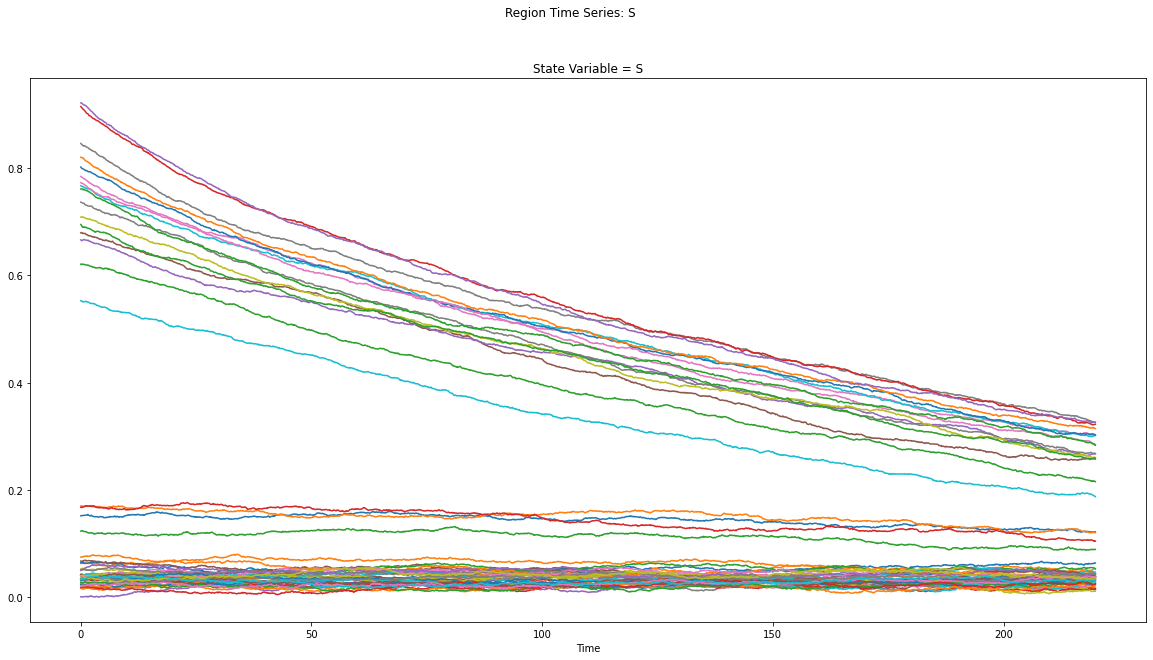

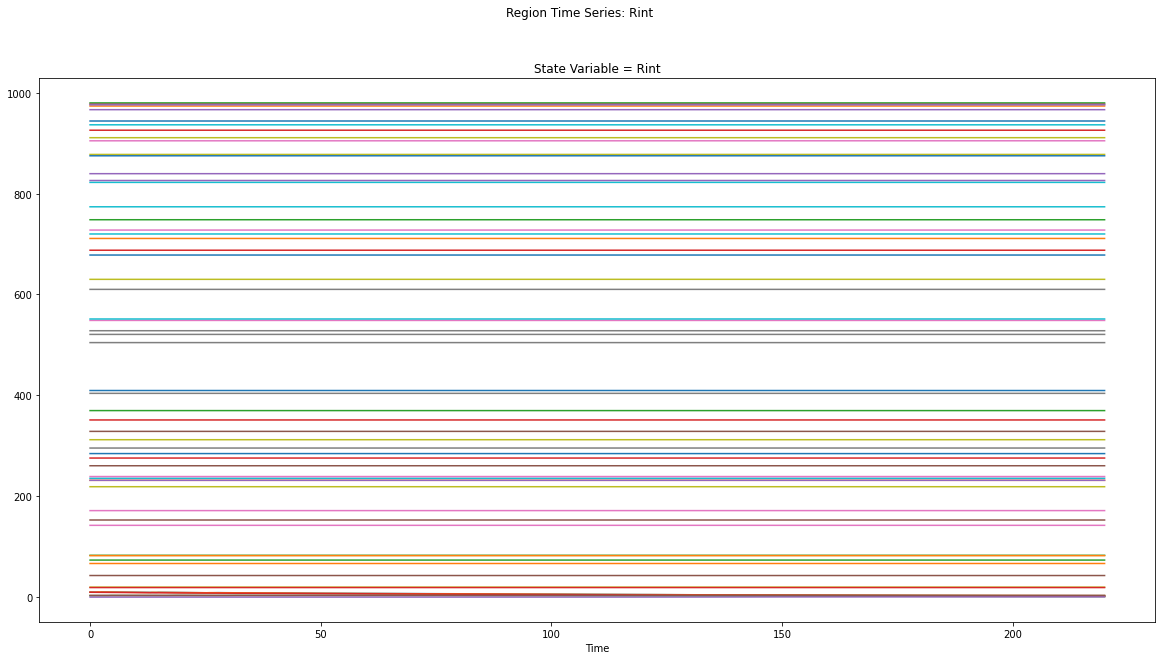

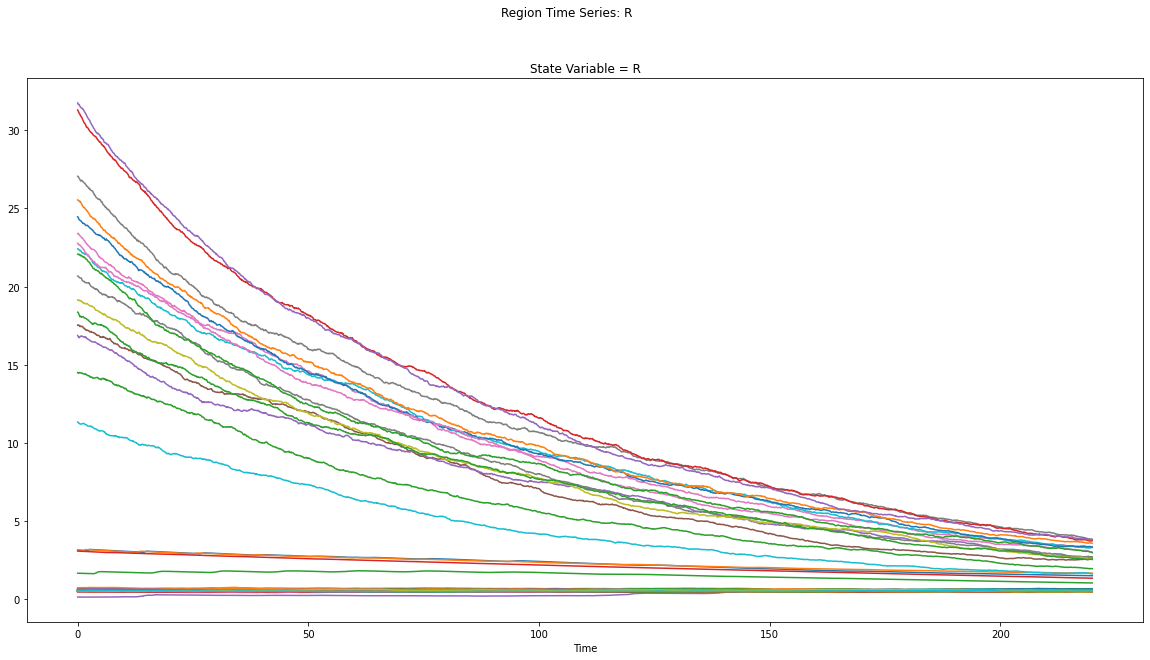

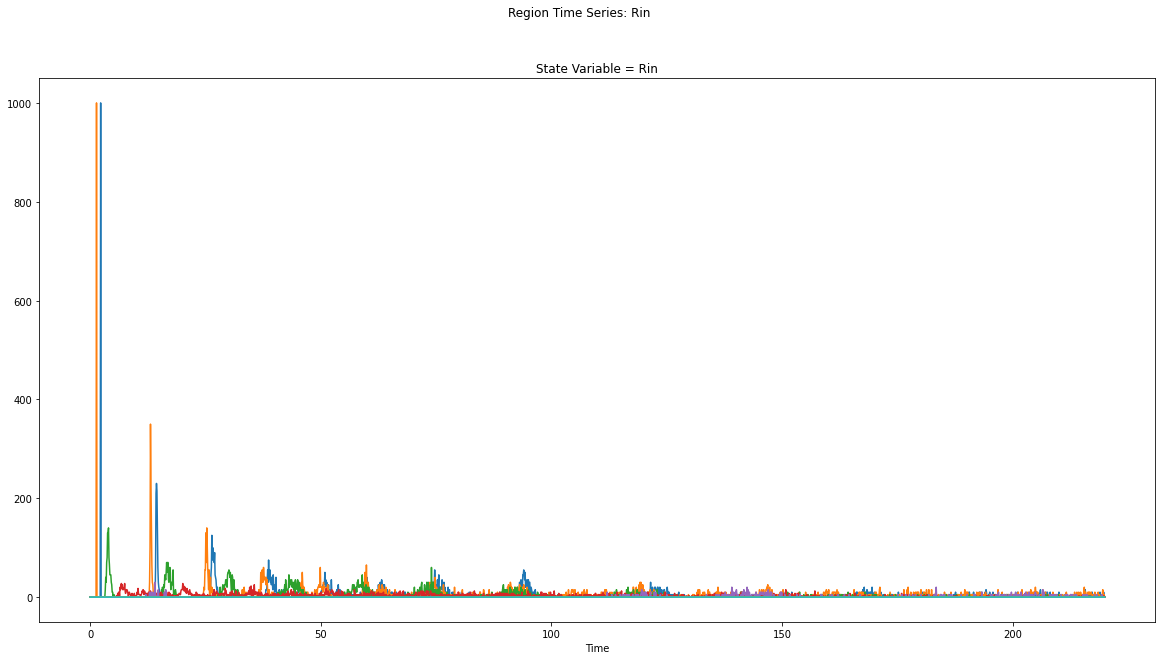

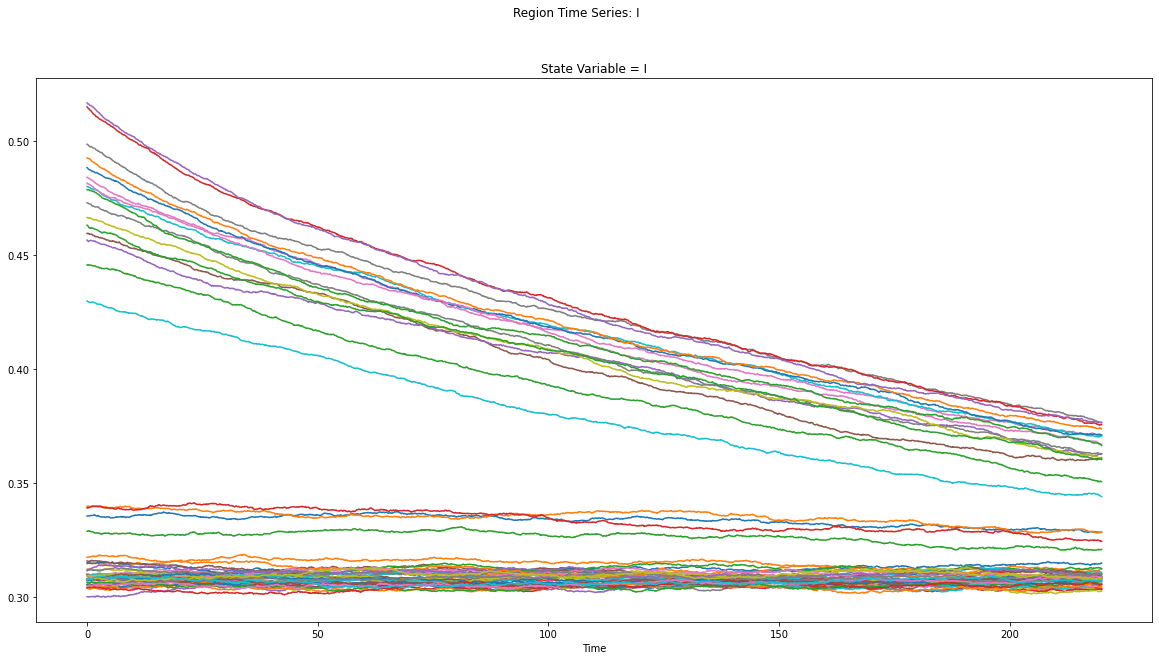

In [18]:
# Plot TVB time series
source_ts.plot_timeseries(plotter_config=plotter.config, 
                          hue="Region" if source_ts.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                          per_variable=source_ts.shape[1] > MAX_VARS_IN_COLS, 
                          figsize=FIGSIZE);

In [19]:
# # TVB time series raster plot:
# if source_ts.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
#     source_ts.plot_raster(plotter_config=plotter.config, 
#                           per_variable=source_ts.shape[1] > MAX_VARS_IN_COLS,
#                           figsize=FIGSIZE);

2021-03-01 15:14:24,768 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-03-01 15:14:24,782 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-03-01 15:14:25,355 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-03-01 15:14:26,085 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-03-01 15:14:26,550 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-03-01 15:14:27,079 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


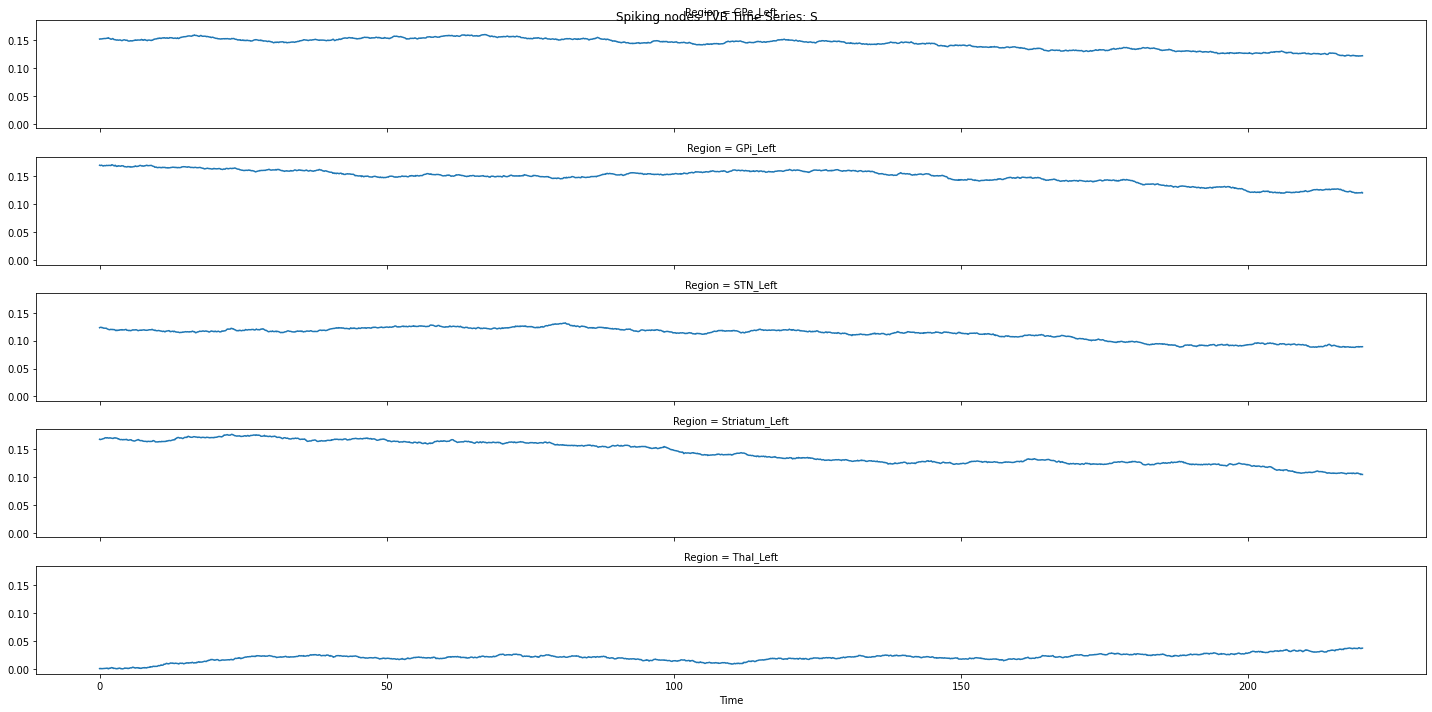

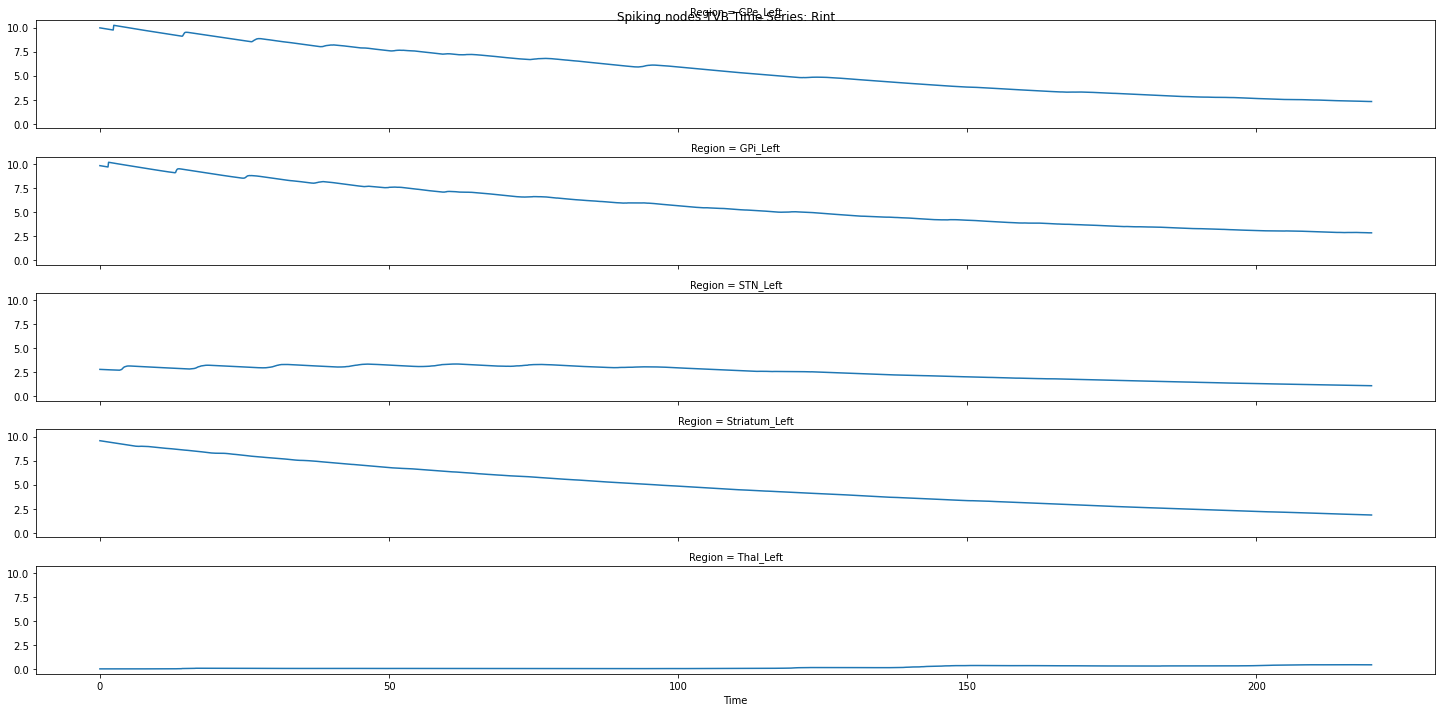

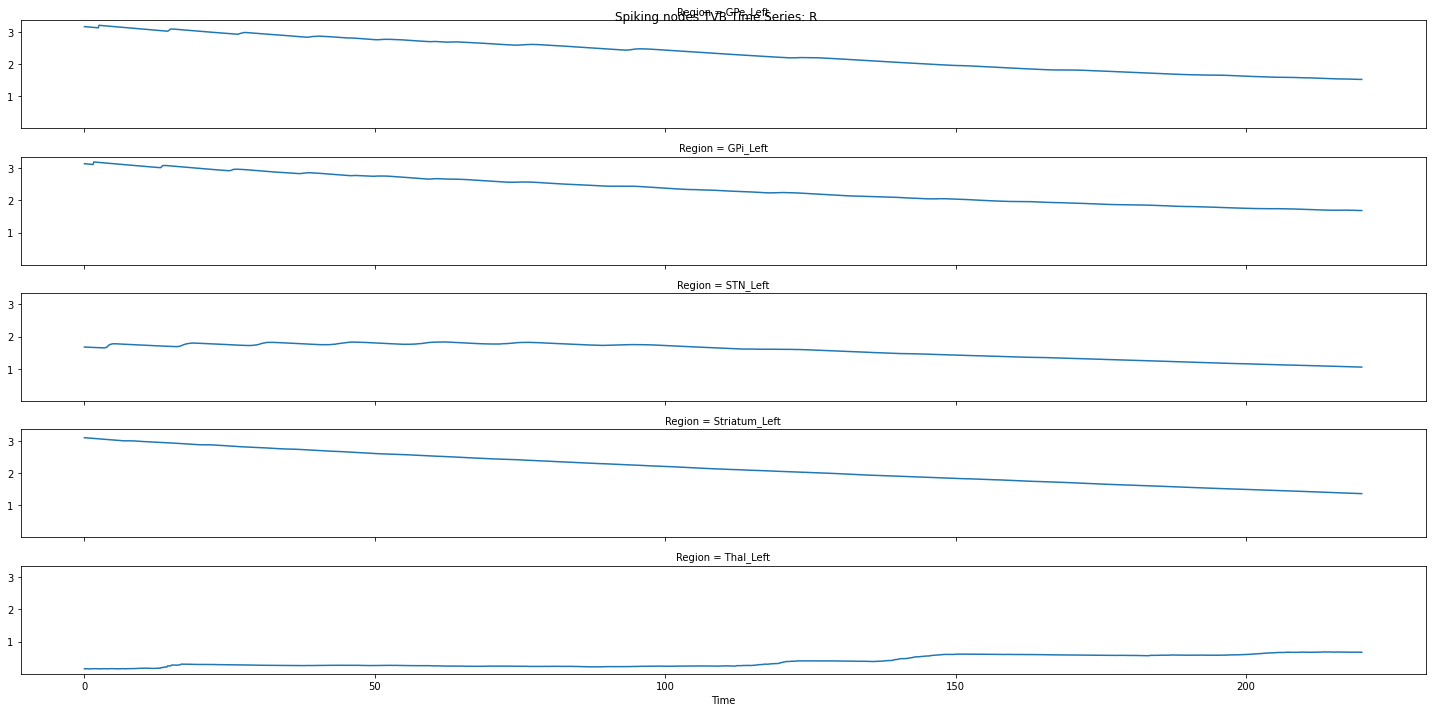

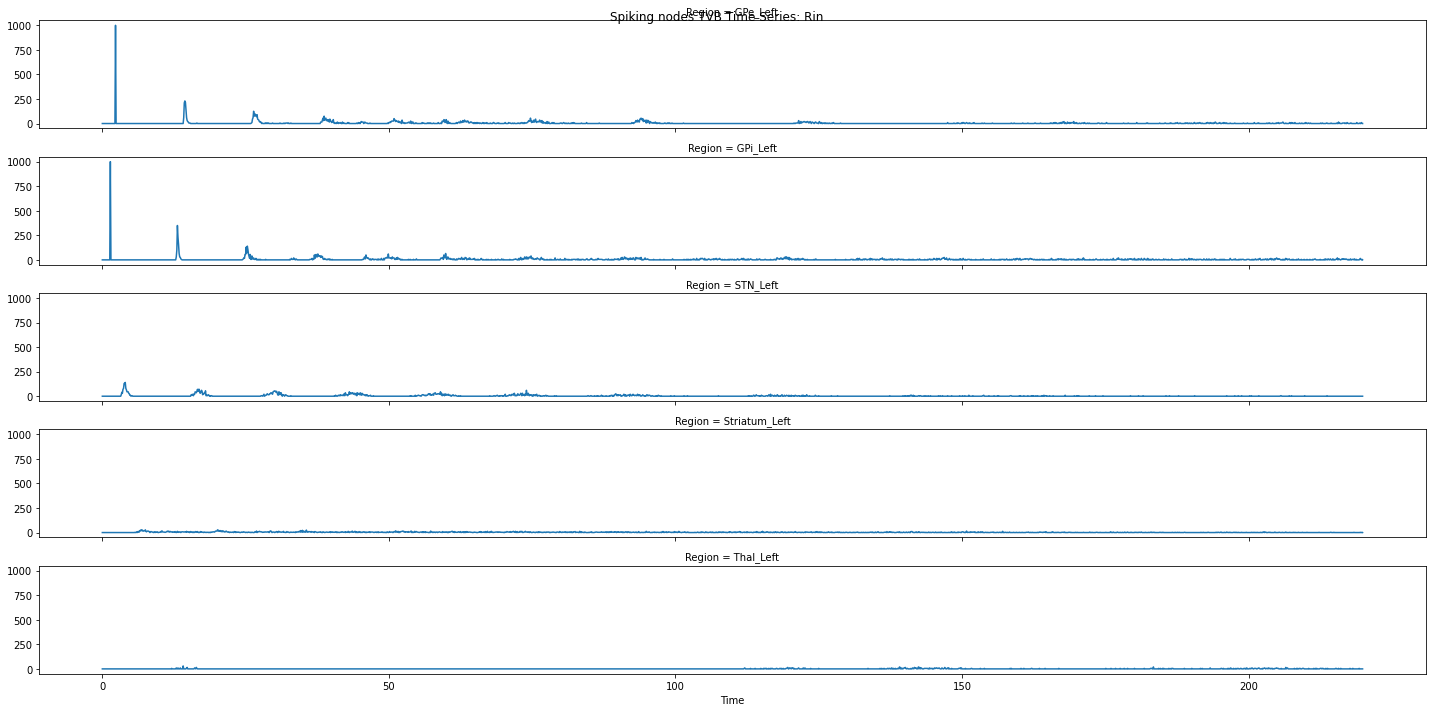

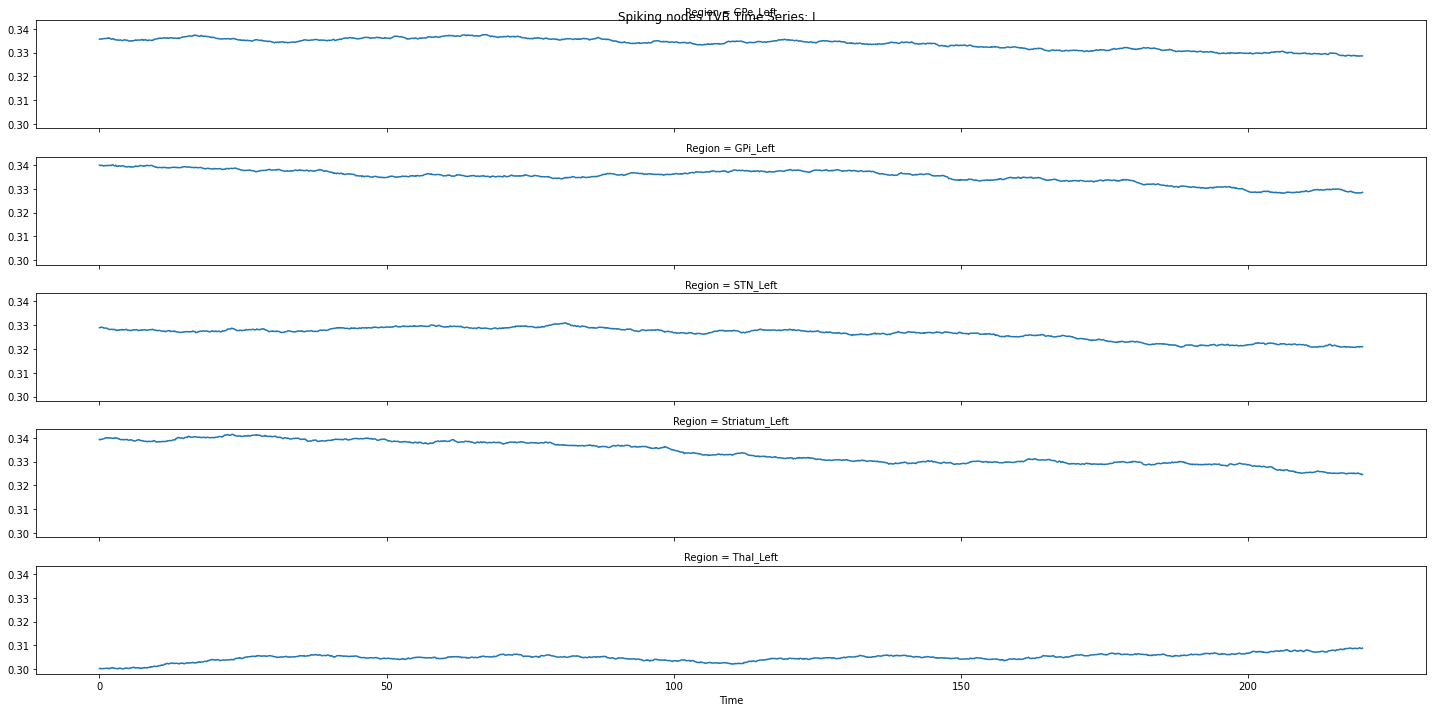

In [20]:
# Focus on the nodes modelled in ANNarchy: 
n_spiking_nodes = len(simulator.tvb_spikeNet_interface.spiking_nodes_ids)
source_ts_ann = source_ts[:, :, simulator.tvb_spikeNet_interface.spiking_nodes_ids]
source_ts_ann.plot_timeseries(plotter_config=plotter.config, 
                               hue="Region" if source_ts_ann.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                               per_variable=source_ts_ann.shape[1] > MAX_VARS_IN_COLS, 
                               figsize=FIGSIZE, figname="Spiking nodes TVB Time Series");

In [21]:
# # Focus on the nodes modelled in ANNarchy: raster plot
# if source_ts_ann.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
#     source_ts_ann.plot_raster(plotter_config=plotter.config, 
#                                per_variable=source_ts_ann.shape[1] > MAX_VARS_IN_COLS,
#                                figsize=FIGSIZE, figname="Spiking nodes TVB Time Series Raster");

### Interactive time series plot

In [22]:
# # ...interactively as well
# # For interactive plotting:
# %matplotlib notebook 
# plotter.plot_timeseries_interactive(TimeSeriesRegion().from_xarray_DataArray(source_ts._data, 
#                                                                              connectivity=source_ts.connectivity))

### Spiking Network plots

In [23]:
from tvb_multiscale.tvb_elephant.spiking_network_analyser import SpikingNetworkAnalyser
# Create a SpikingNetworkAnalyzer:
spikeNet_analyzer = \
    SpikingNetworkAnalyser(spikeNet=annarchy_network,
                           start_time=period, end_time=simulation_length, 
                           period=period, transient=transient,
                           time_series_output_type="TVB", return_data=True,
                           # elephant_mean_firing_rate=False,
                           force_homogeneous_results=True, connectivity=simulator.connectivity)

### Plot spikes' raster and mean spike rates and correlations

In [24]:
# Spikes rates and correlations per Population and Region
spikes_res = \
    spikeNet_analyzer.\
        compute_spikeNet_spikes_rates_and_correlations(
            populations_devices=None, regions=None,
            rates_methods=[], rates_kwargs=[{}],rate_results_names=[],
            corrs_methods=[], corrs_kwargs=[{}], corrs_results_names=[], bin_kwargs={},
            data_method=spikeNet_analyzer.get_spikes_from_device, data_kwargs={},
            return_devices=False
        );

/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:848: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  "input spiketrain".format(n_discarded))


<xarray.DataArray "Mean Populations' Spikes' Rates" (Population: 4, Region: 5)>
array([[        nan,         nan, 27.91457258,         nan,  7.23618083],
       [35.854271  , 44.7738689 ,         nan,         nan,         nan],
       [        nan,         nan,         nan, 34.39698458,         nan],
       [        nan,         nan,         nan, 15.15075362,         nan]])
Coordinates:
  * Region      (Region) object 'GPe_Left' 'GPi_Left' ... 'Thal_Left'
  * Population  (Population) object 'E_spikes' 'I_spikes' ... 'IiSN_spikes'
<xarray.DataArray "Populations' Correlation Coefficient" (Population_i: 4, Population_j: 4, Region_i: 5, Region_j: 5)>
array([[[[        nan,         nan,         nan,         nan,
                  nan],
         [        nan,         nan,         nan,         nan,
                  nan],
         [        nan,         nan,  1.        ,         nan,
          -0.04148304],
         [        nan,         nan,         nan,         nan,
                  nan],
 

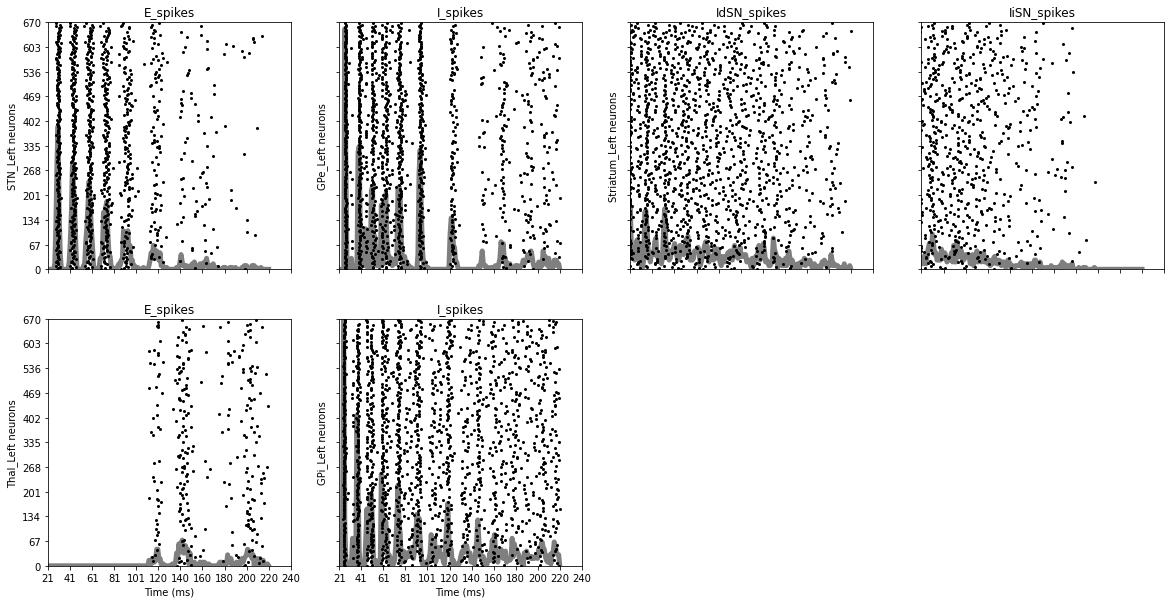

<Figure size 432x288 with 0 Axes>

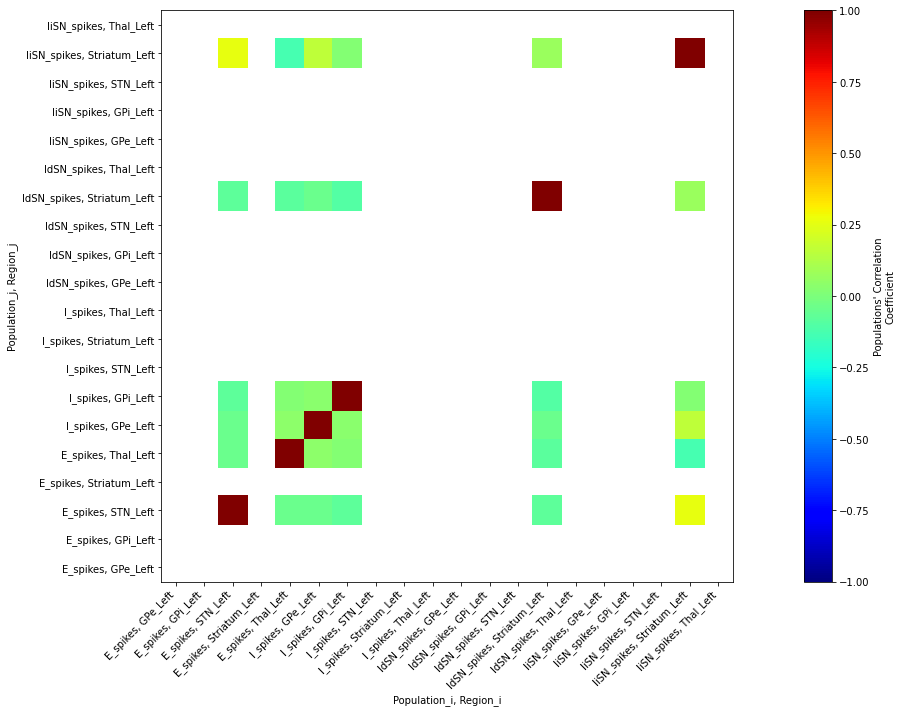

In [25]:
if spikes_res:
    print(spikes_res["mean_rate"])
    print(spikes_res["spikes_correlation_coefficient"])
    # Plot spikes' rasters together with mean population's spikes' rates' time series
    if plotter:
        plotter.plot_spike_events(spikes_res["spikes"], rates=spikes_res["mean_rate_time_series"],
                                  figsize=FIGSIZE) #  
        from tvb_multiscale.core.plot.correlations_plot import plot_correlations
        plot_correlations(spikes_res["spikes_correlation_coefficient"], plotter)

In [26]:
print("Mean spike rates:")
for pop in spikes_res["mean_rate"].coords["Population"]:
    for reg in spikes_res["mean_rate"].coords["Region"]:
        if not np.isnan(spikes_res["mean_rate"].loc[pop, reg]):
            print("%s - %s: %g" % (pop.values.item().split("_spikes")[0], reg.values.item(), 
                                   spikes_res["mean_rate"].loc[pop, reg].values.item()))

Mean spike rates:
E - STN_Left: 27.9146
E - Thal_Left: 7.23618
I - GPe_Left: 35.8543
I - GPi_Left: 44.7739
IdSN - Striatum_Left: 34.397
IiSN - Striatum_Left: 15.1508


In [27]:
if spikes_res and writer:
    writer.write_object(spikes_res["spikes"].to_dict(), 
                        path=os.path.join(config.out.FOLDER_RES,  "Spikes") + ".h5");
    writer.write_object(spikes_res["mean_rate"].to_dict(),
                        path=os.path.join(config.out.FOLDER_RES,
                                          spikes_res["mean_rate"].name) + ".h5");
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(
                              spikes_res["mean_rate_time_series"]._data,
                               connectivity=spikes_res["mean_rate_time_series"].connectivity),
                           os.path.join(config.out.FOLDER_RES,
                                        spikes_res["mean_rate_time_series"].title) + ".h5",
                           recursive=False);
    writer.write_object(spikes_res["spikes_correlation_coefficient"].to_dict(),
                        path=os.path.join(config.out.FOLDER_RES,
                                          spikes_res["spikes_correlation_coefficient"].name) + ".h5");

2021-03-01 15:14:33,616 - INFO - tvb_multiscale.core.io.h5_writer - Starting to write dict to: /home/docker/packages/tvb-multiscale/examples/tvb_annarchy/notebooks/outputs/outputs_Izhikevich_annarchy/TVBcortex/rs/res/Spikes.h5
2021-03-01 15:14:33,616 - INFO - tvb_multiscale.core.io.h5_writer - Starting to write dict to: /home/docker/packages/tvb-multiscale/examples/tvb_annarchy/notebooks/outputs/outputs_Izhikevich_annarchy/TVBcortex/rs/res/Spikes.h5
2021-03-01 15:14:33,645 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> times to h5 file as a numpy array dataset !

2021-03-01 15:14:33,645 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> times to h5 file as a numpy array dataset !

2021-03-01 15:14:33,649 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> senders to h5 file as a numpy array dataset !

2021-03-01 15:14:33,649 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> senders to h5 file as a numpy

2021-03-01 15:14:33,700 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/E_spikes/Thal_Left" (2 members)> dataset <class 'numpy.ndarray'> senders:
[  0   0   1   1   2   2   3   3   4   4   4   4   4   5   6   6   7   7
   7   7   8   8   9   9   9   9  12  12  13  13  13  13  16  16  17  17
  18  18  19  20  21  21  21  21  24  25  26  27  27  29  29  30  30  30
  30  31  31  32  33  33  34  34  34  34  36  36  37  37  37  37  38  38
  39  39  42  42  43  43  44  44  45  46  47  47  48  48  50  51  51  52
  52  53  53  54  54  55  55  55  55  57  57  58  59  59  61  62  62  63
  63  64  66  66  67  67  68  68  69  69  69  69  70  71  72  72  72  73
  73  74  75  76  76  77  78  78  79  79  80  80  81  81  83  83  83  83
  85  85  85  87  88  88  89  89  90  90  91  92  93  94  94  95  97 100
 100 104 104 105 105 106 106 106 106 108 108 108 108 108 110 111 111 111
 112 112 112 113 113 117 117 120 120 120 122 122 122 122 123 124 125 126
 126 127 127 127 1

2021-03-01 15:14:33,794 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/IiSN_spikes/Striatum_Left" (2 members)> dataset <class 'numpy.ndarray'> times:
[ 19.6   39.15  59.85  86.15  23.85  42.35  59.2  101.75  11.5   37.85
  69.1   11.3   29.55  60.75  16.4   31.45  81.8   11.5   27.2   57.35
  90.55 116.05   9.9   29.35  53.85 126.8   11.55  28.7   56.75  72.9
 157.15  12.4   38.7   78.45  10.65  24.8   44.85  71.05 100.05  25.5
  45.6   72.4   10.75  42.6   80.4  106.3   10.4   26.7   50.6   89.1
 123.65  11.65  30.4   62.75  95.25  23.15  50.9   73.6  163.25  20.2
  50.15  91.35  14.4   29.35  52.55  77.75 111.    20.8   64.8  128.3
  18.4   36.5   56.8   20.55  49.1   68.95  10.5   30.85  59.55 118.7
  13.5   30.35  61.1   10.45  27.75  53.85  85.9  108.4   11.4   34.05
  52.4  116.25  16.65  50.9   76.1  169.05  24.3   57.65  11.85  54.55
  13.05  32.95  51.2  125.5    9.35  24.6   45.45  67.95  94.65  19.05
  39.15  62.55 154.5   11.15  29.85  53.9

2021-03-01 15:14:33,804 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/IiSN_spikes/Striatum_Left" (2 members)> dataset <class 'numpy.ndarray'> senders:
[  0   0   0   0   1   1   1   1   2   2   2   3   3   3   4   4   4   5
   5   5   5   5   6   6   6   6   7   7   7   7   7   8   8   8   9   9
   9   9   9  10  10  10  11  11  11  11  12  12  12  12  12  13  13  13
  13  14  14  14  14  15  15  15  16  16  16  16  16  17  17  17  18  18
  18  19  19  19  20  20  20  20  21  21  21  22  22  22  22  22  23  23
  23  23  24  24  24  24  25  25  26  26  27  27  27  27  28  28  28  28
  28  29  29  29  29  30  30  30  31  31  31  31  31  32  32  32  32  33
  33  33  33  33  34  34  34  35  35  35  35  36  36  36  37  37  37  38
  38  38  39  39  39  39  39  40  40  40  40  41  41  41  42  42  42  42
  42  43  43  43  43  44  44  44  45  45  45  45  45  46  46  46  47  47
  47  47  48  48  48  48  49  49  49  50  50  50  50  51  51  51  52  52
  52  53  5

2021-03-01 15:14:33,894 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/coords/Population" (2 members)> dataset <class 'numpy.ndarray'> dims:
['Population'] !

2021-03-01 15:14:33,898 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/coords/Population" (2 members)> dataset <class 'numpy.ndarray'> data:
['E_spikes' 'I_spikes' 'IdSN_spikes' 'IiSN_spikes'] !

2021-03-01 15:14:33,898 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/coords/Population" (2 members)> dataset <class 'numpy.ndarray'> data:
['E_spikes' 'I_spikes' 'IdSN_spikes' 'IiSN_spikes'] !

2021-03-01 15:14:33,912 - INFO - tvb_multiscale.core.io.h5_writer - dict has been written to file: /home/docker/packages/tvb-multiscale/examples/tvb_annarchy/notebooks/outputs/outputs_Izhikevich_annarchy/TVBcortex/rs/res/Mean Populations' Spikes' Rates.h5
2021-03-01 15:14:33,912 - INFO - tvb_multiscale.core.io.h5_writer - dict has been written t

2021-03-01 15:14:34,135 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'tuple'> dims to h5 file as a numpy array dataset !

2021-03-01 15:14:34,135 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'tuple'> dims to h5 file as a numpy array dataset !

2021-03-01 15:14:34,138 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> data to h5 file as a numpy array dataset !

2021-03-01 15:14:34,138 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> data to h5 file as a numpy array dataset !

2021-03-01 15:14:34,143 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/coords/Population_i" (2 members)> dataset <class 'numpy.ndarray'> dims:
['Population_i'] !

2021-03-01 15:14:34,143 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/coords/Population_i" (2 members)> dataset <class 'numpy.ndarray'> dims:
['Population_i'] !

2021-03-01 15:14:34,147 - WARNING - tvb_multisca

### Get  SpikingNetwork mean field variable time series and plot them

2021-03-01 15:14:35,268 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-03-01 15:14:36,347 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-03-01 15:14:37,188 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-03-01 15:14:38,218 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-03-01 15:14:39,036 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-03-01 15:14:39,799 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-03-01 15:14:40,549 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries lab

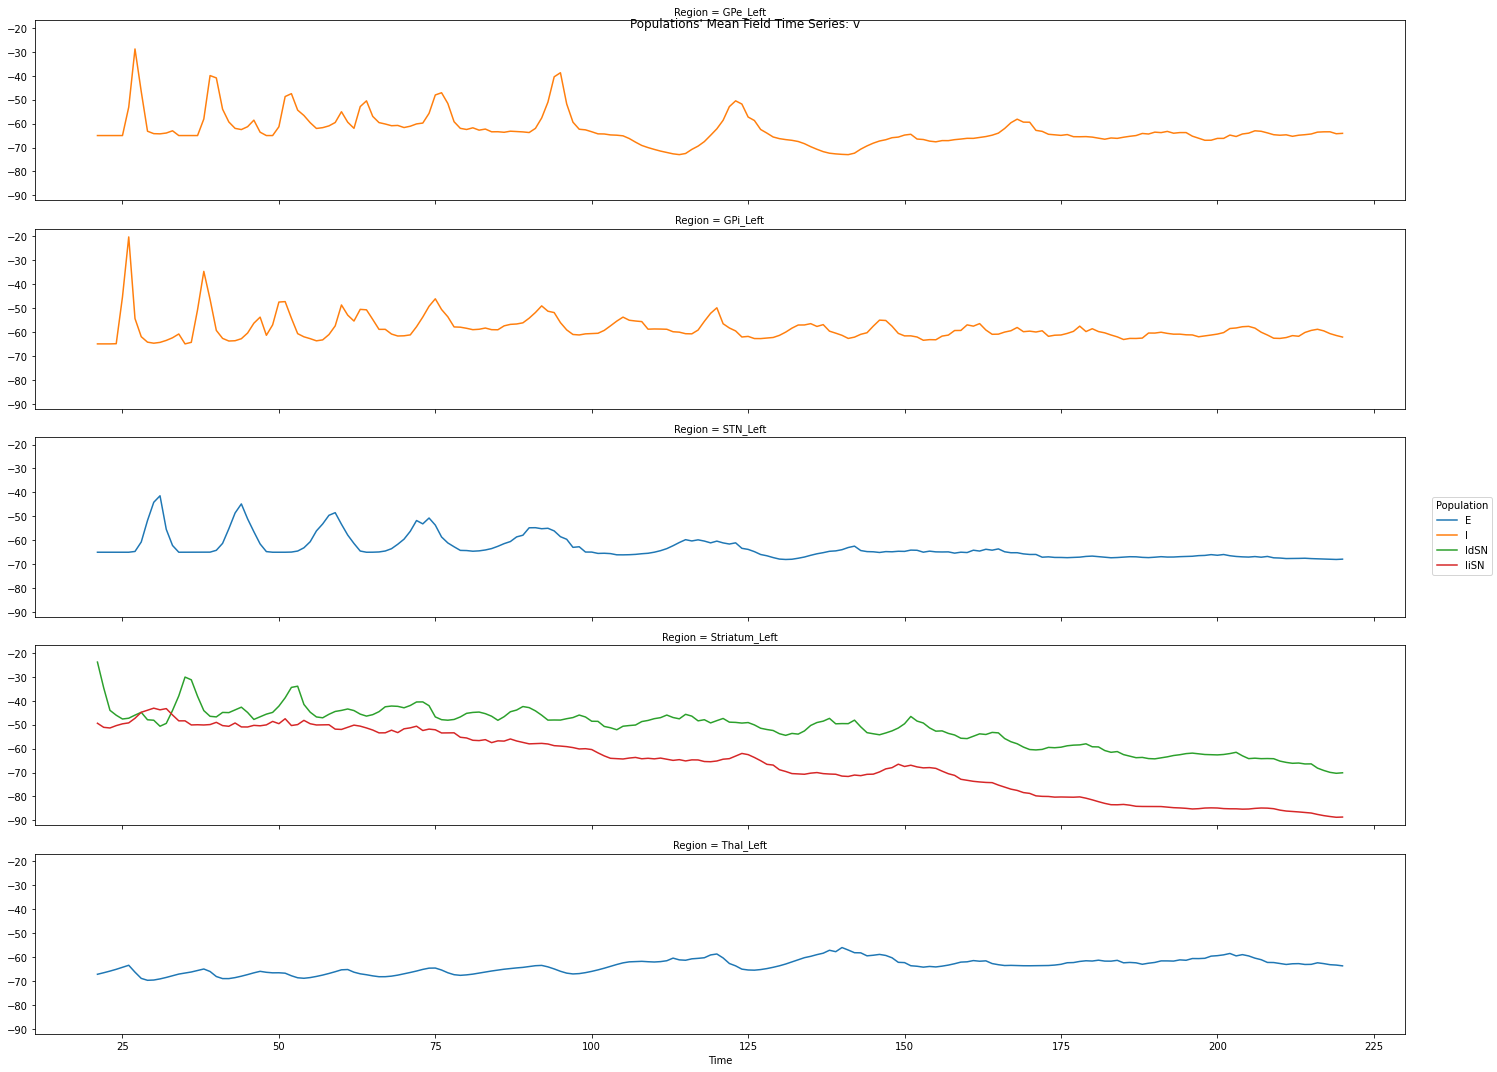

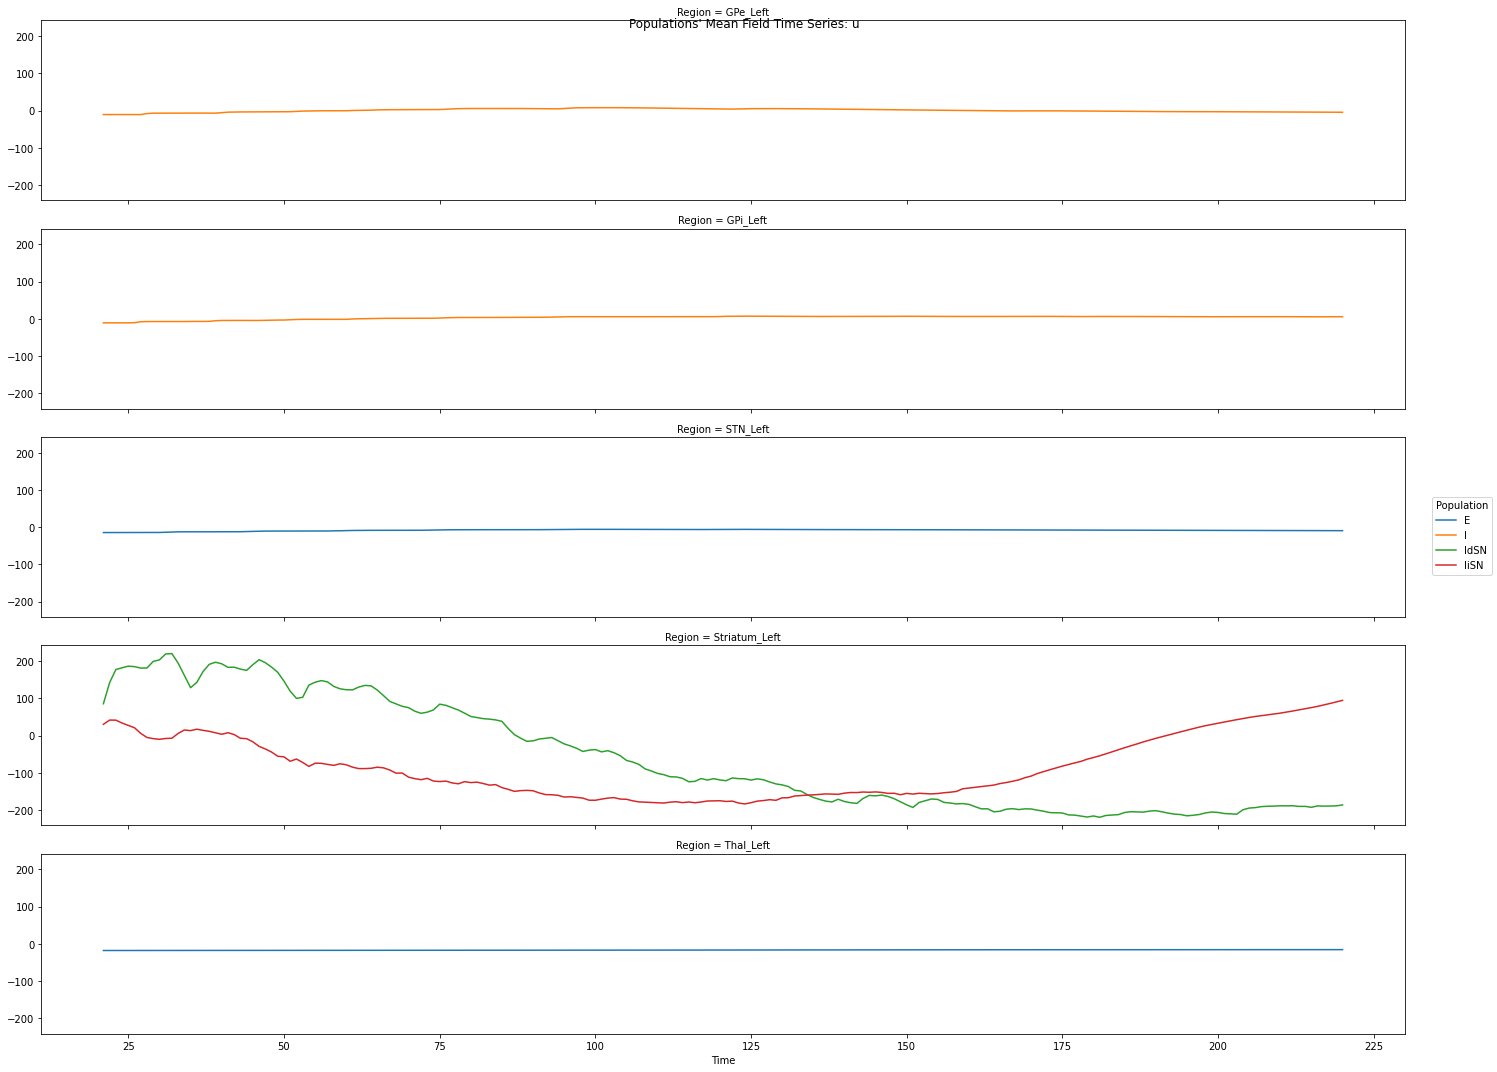

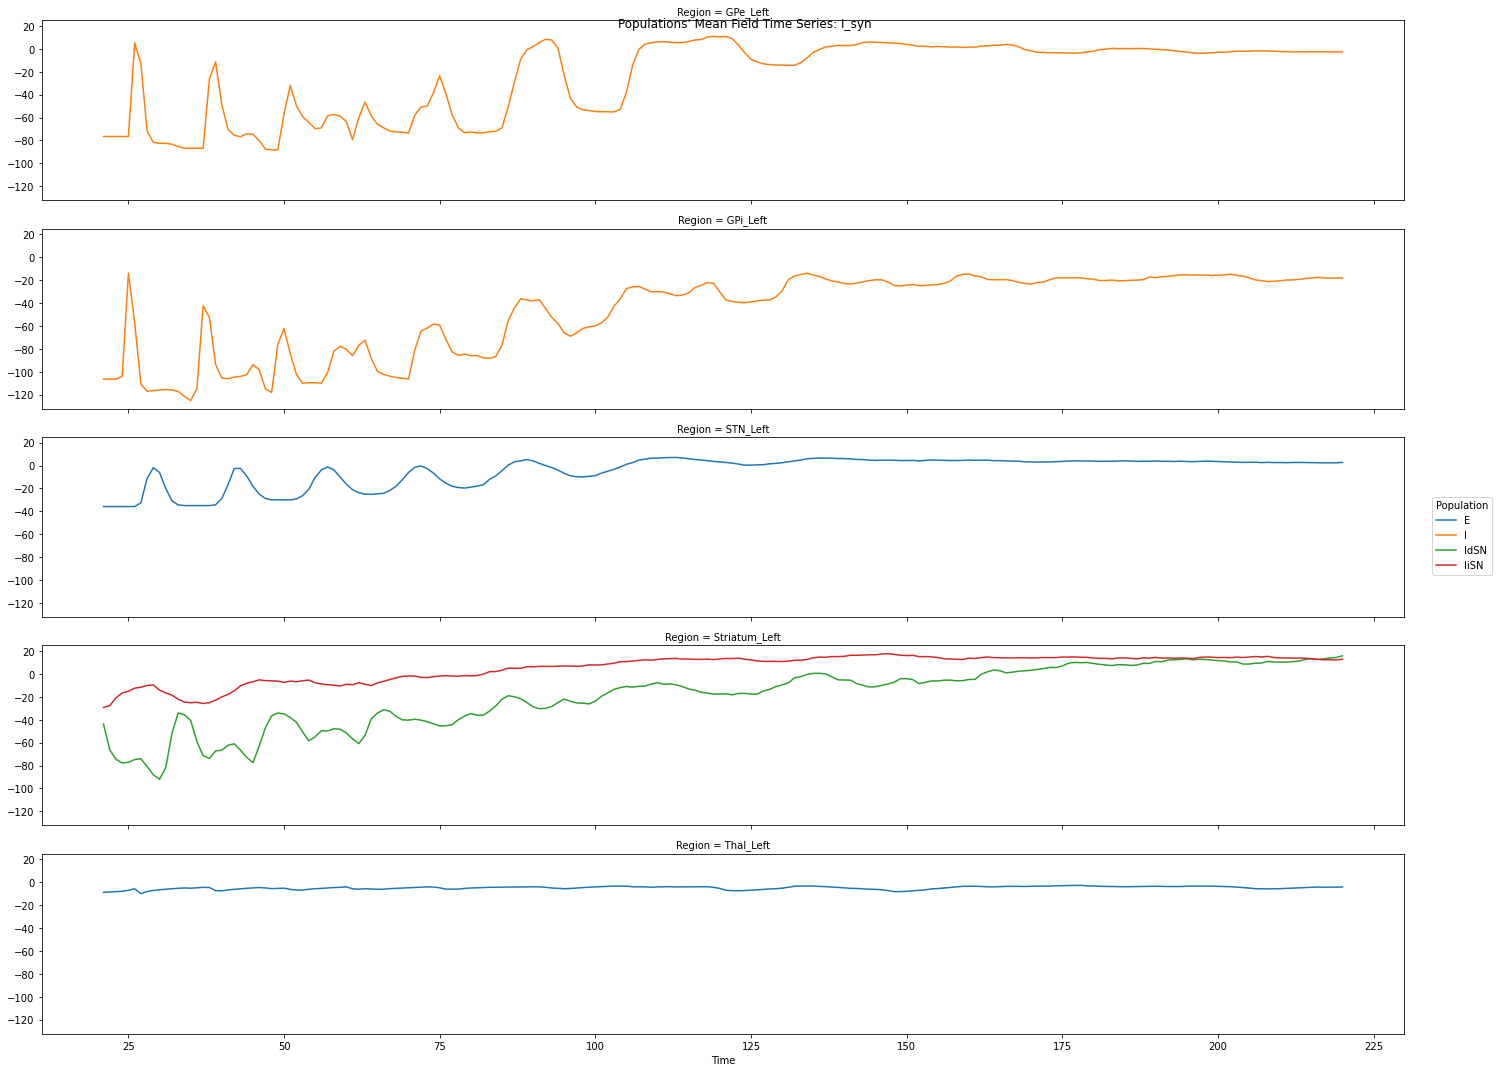

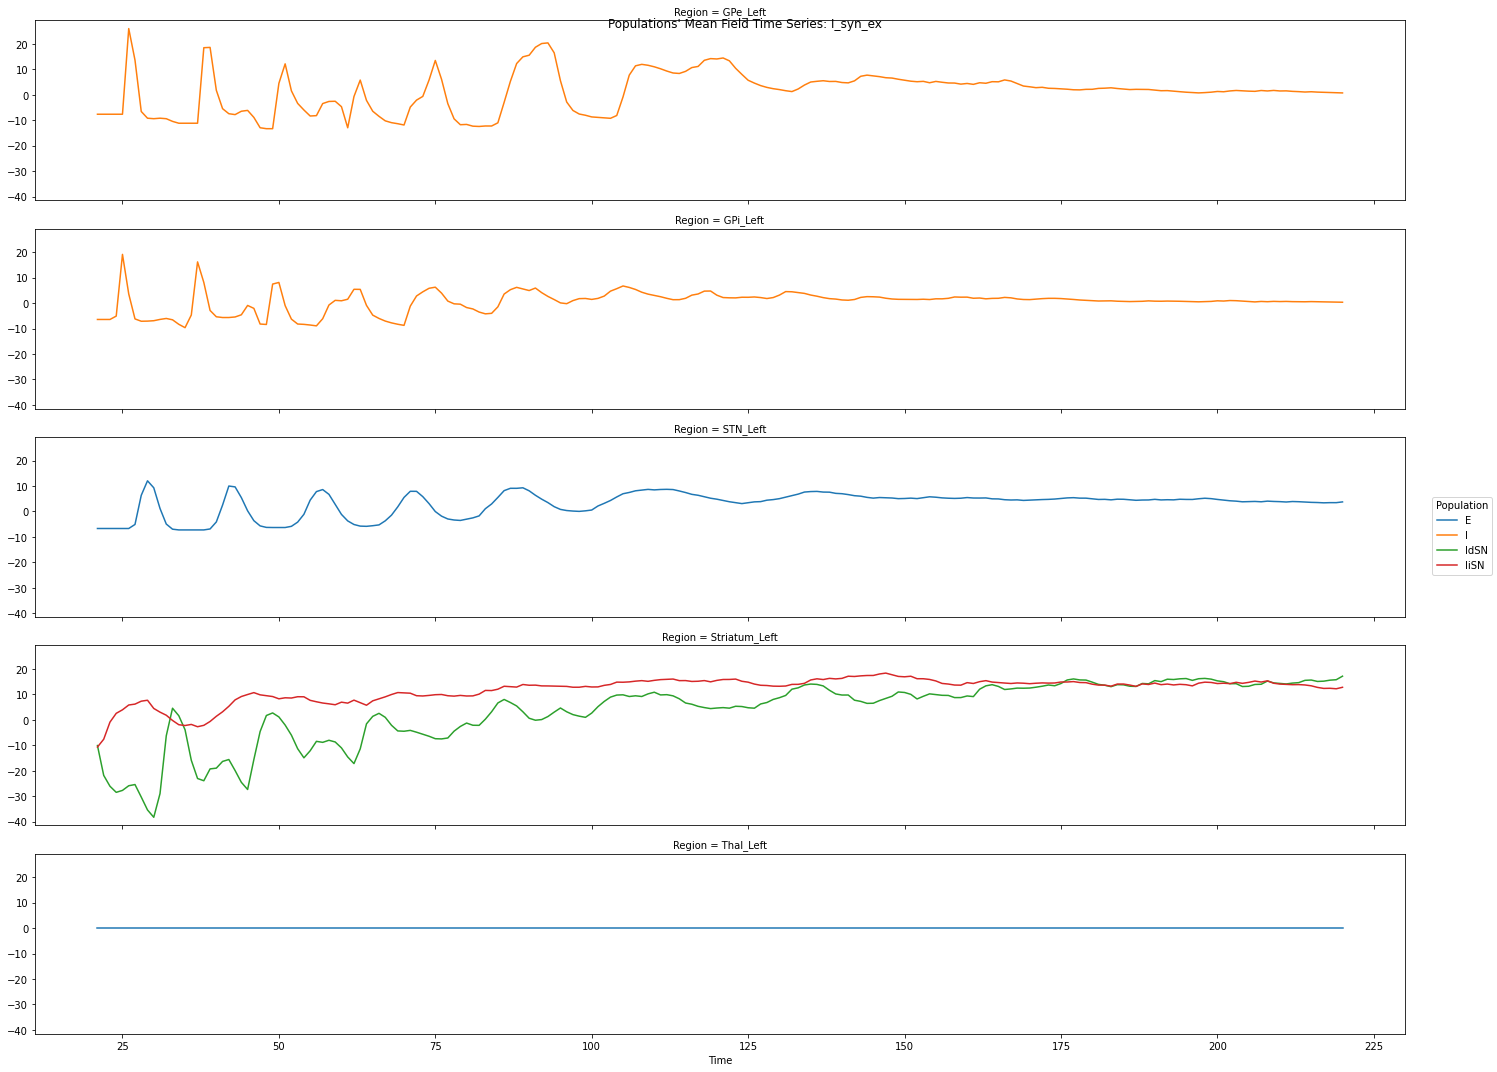

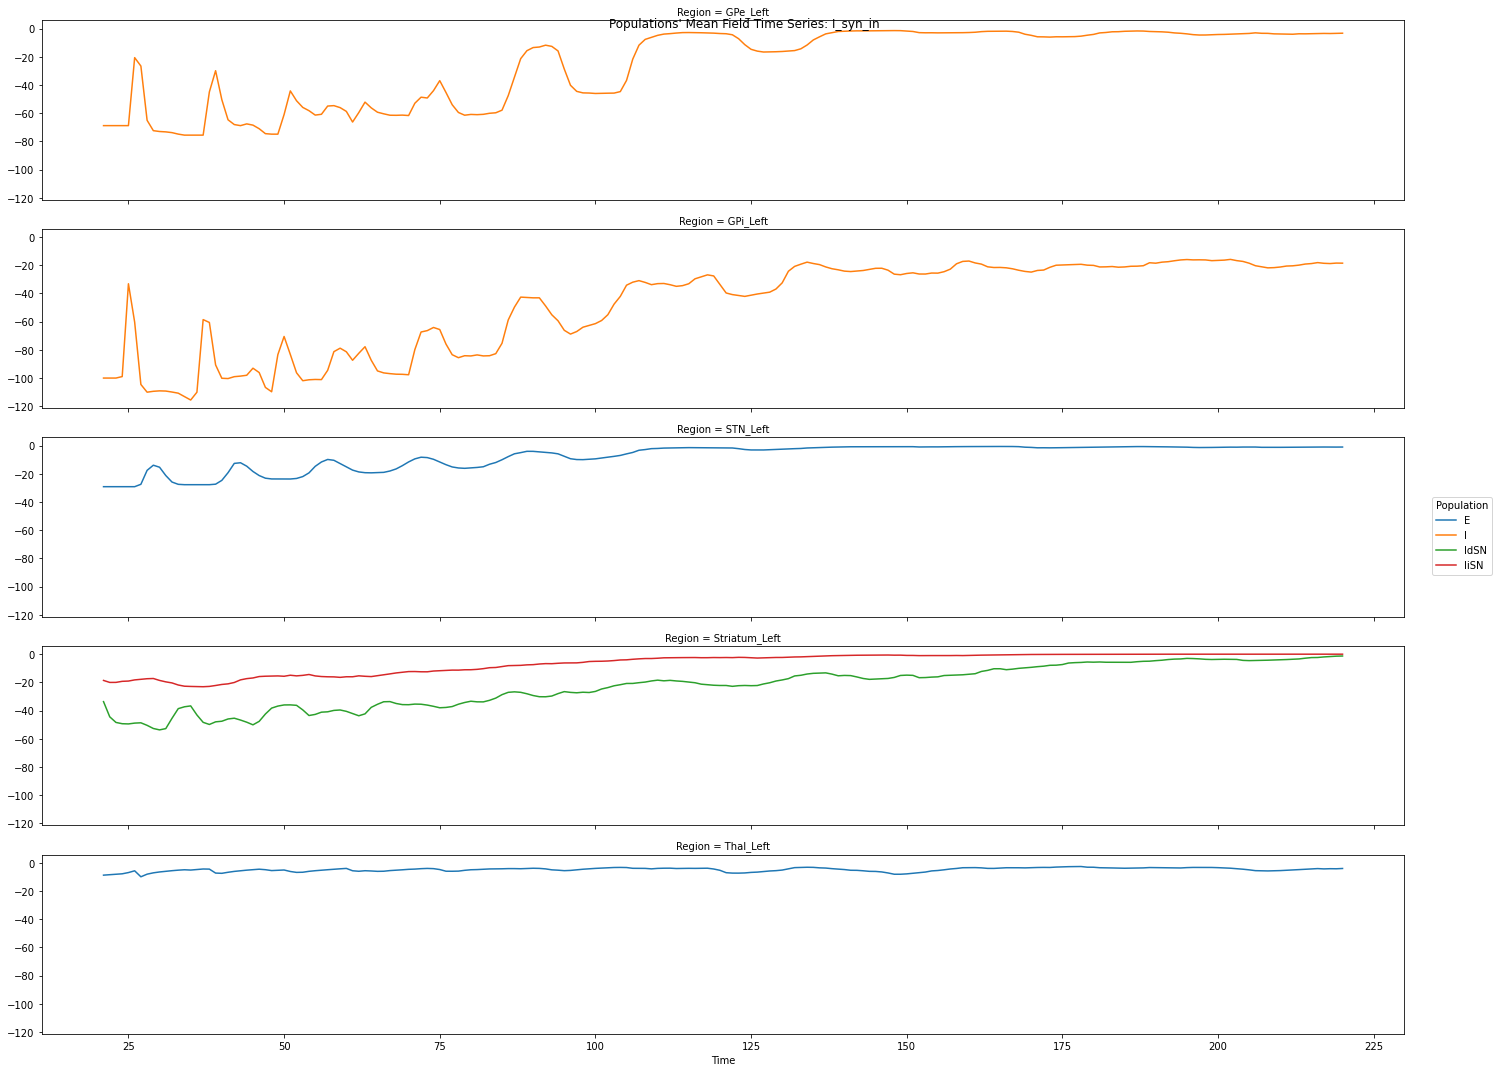

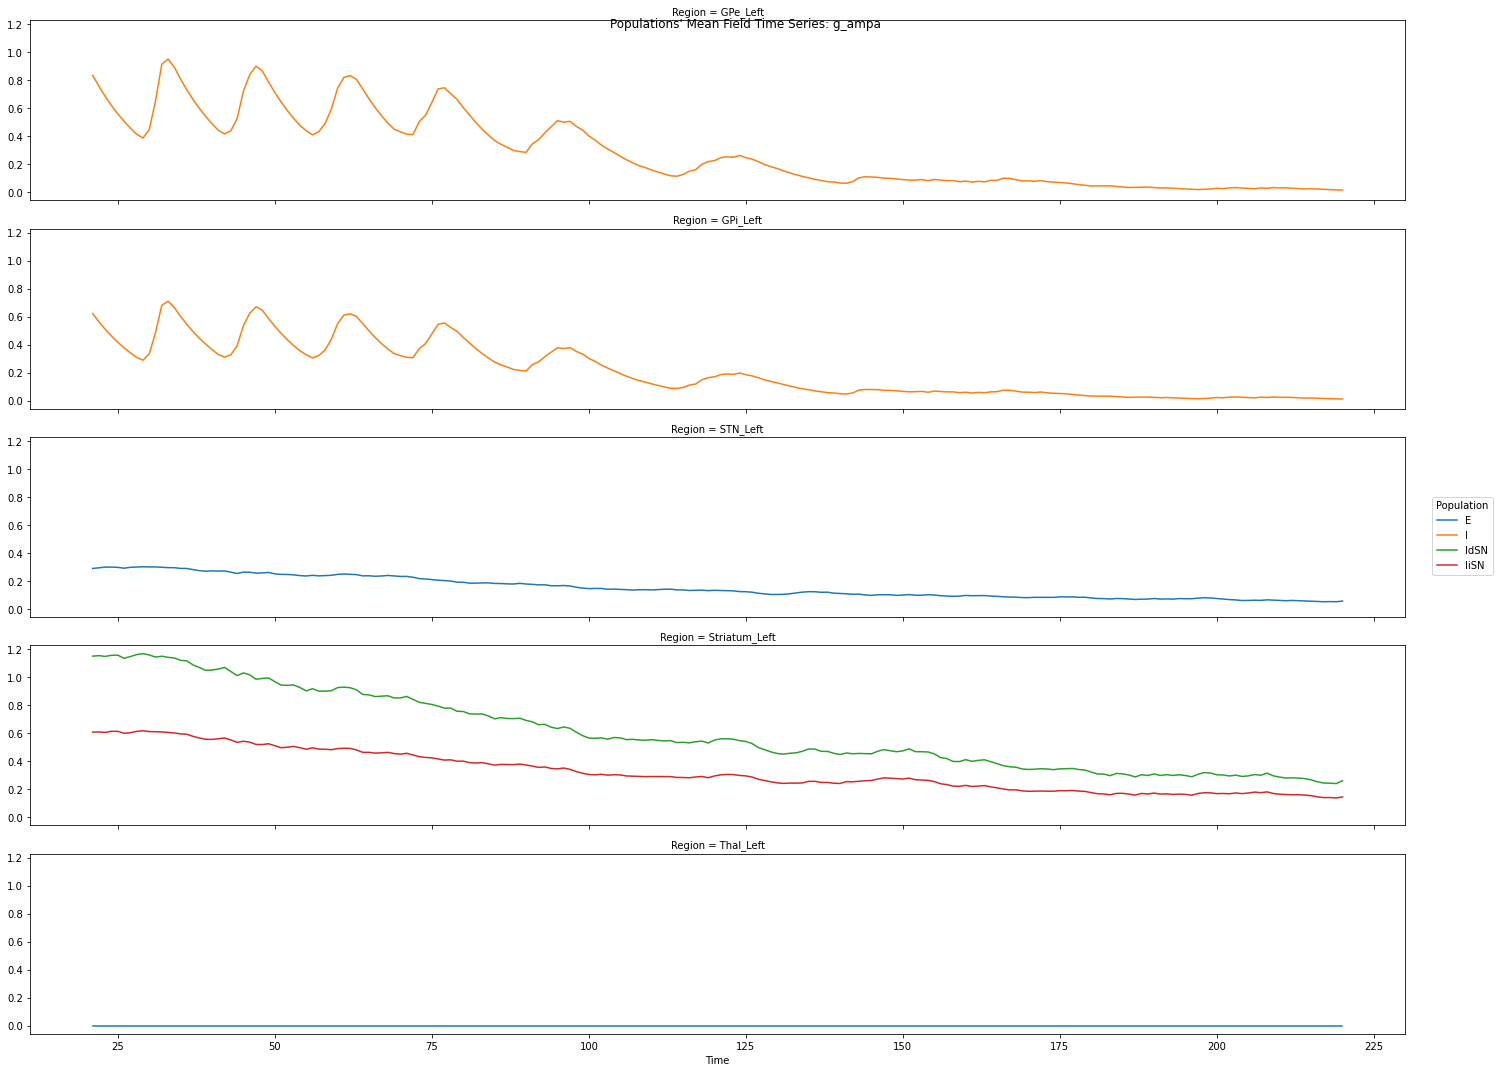

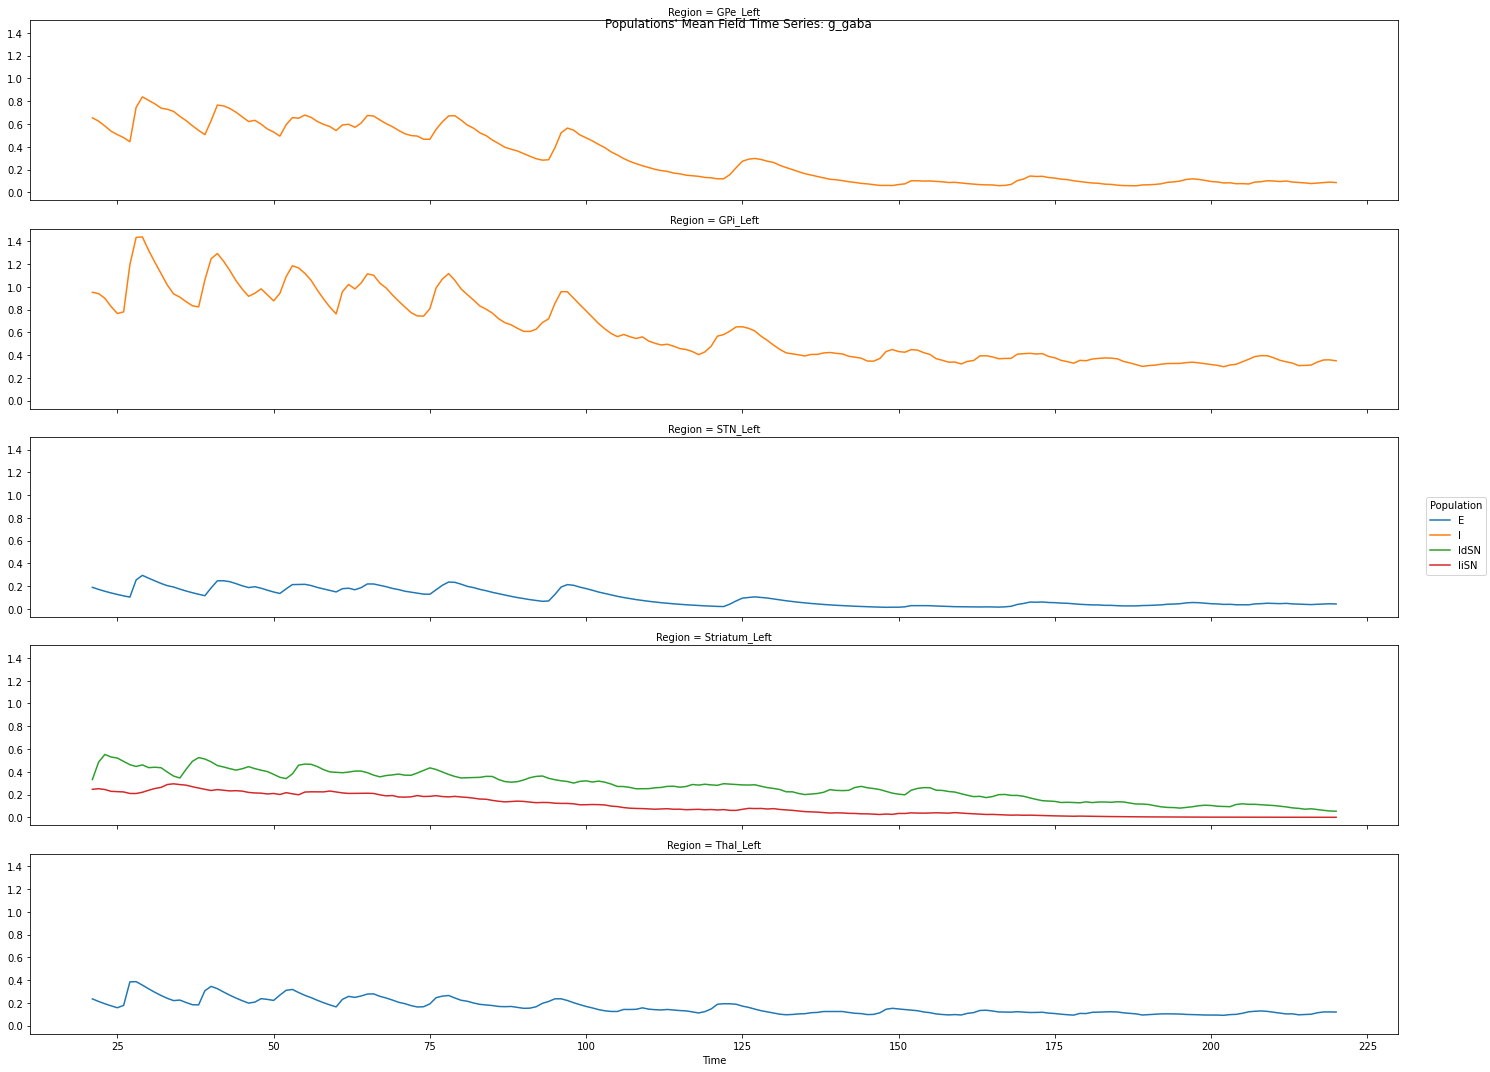

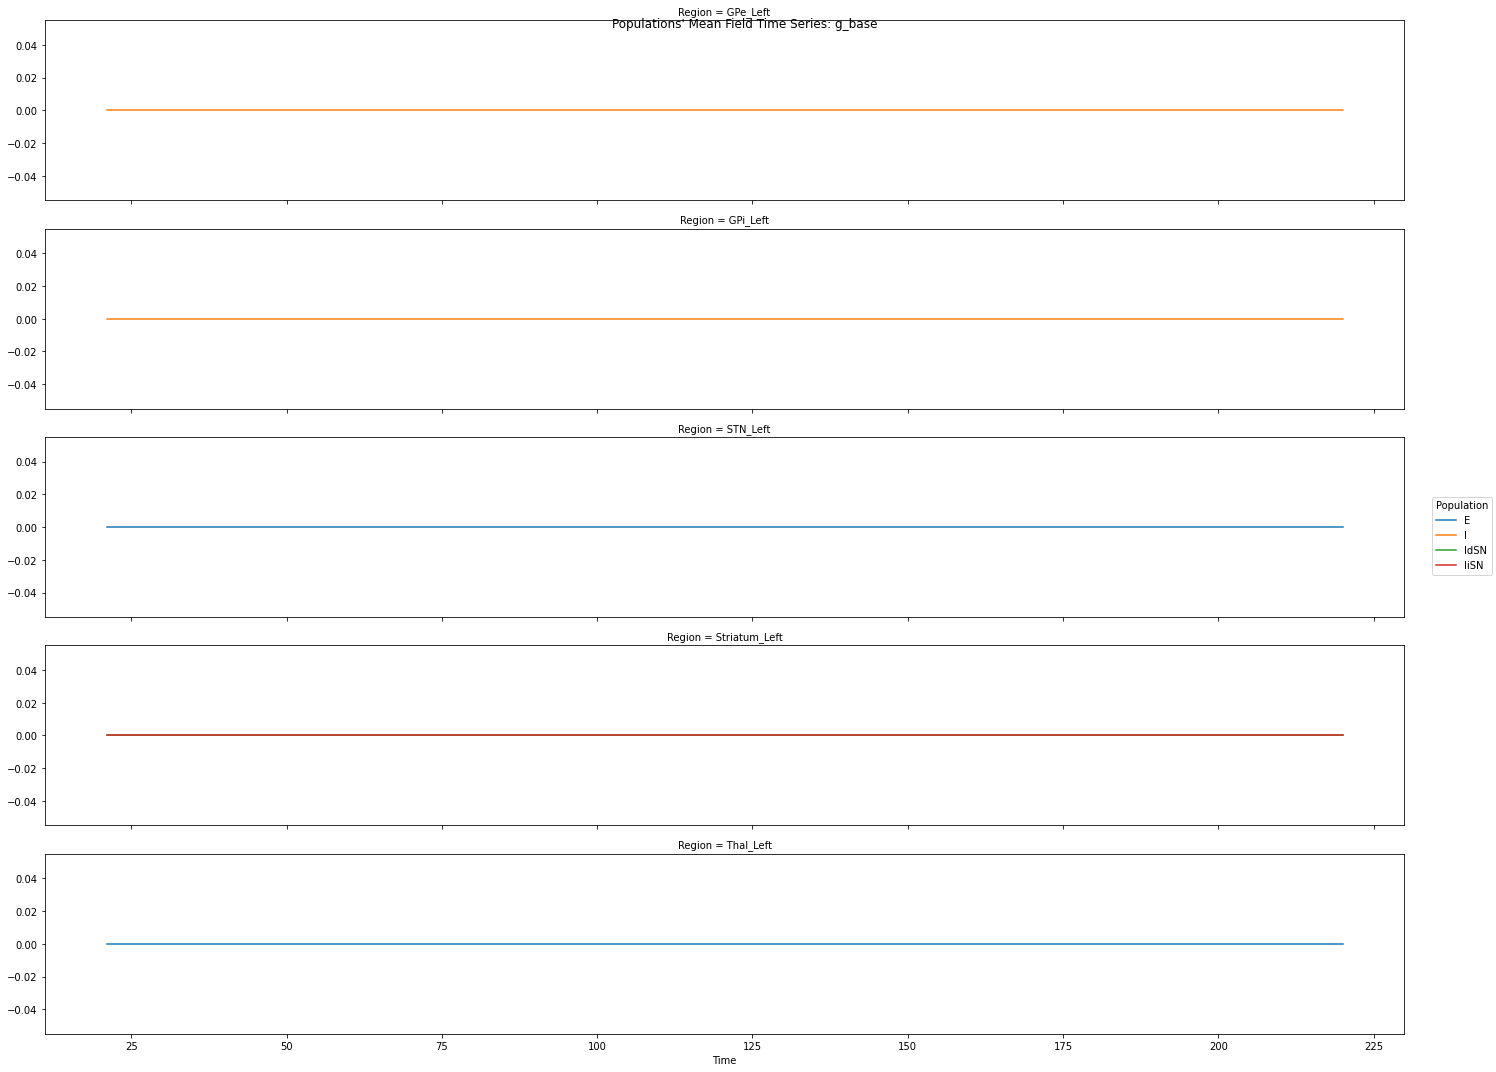

In [28]:
# Continuous time variables' data of spiking neurons
if plot_per_neuron:
    spikeNet_analyzer.return_data = True
else:
    spikeNet_analyzer.return_data = False
spikeNet_ts = \
    spikeNet_analyzer. \
         compute_spikeNet_mean_field_time_series(populations_devices=None, regions=None, variables=None,
                                                 computations_kwargs={}, data_kwargs={}, return_devices=False)
if spikeNet_ts:
    if plot_per_neuron:
        mean_field_ts = spikeNet_ts["mean_field_time_series"]  # mean field
        spikeNet_ts = spikeNet_ts["data_by_neuron"]  # per neuron data
    else:
        mean_field_ts = spikeNet_ts
    if mean_field_ts and mean_field_ts.size > 0:
        mean_field_ts.plot_timeseries(plotter_config=plotter.config, 
                                      per_variable=mean_field_ts.shape[1] > MAX_VARS_IN_COLS)
        if mean_field_ts.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
            mean_field_ts.plot_raster(plotter_config=plotter.config, 
                                      per_variable=mean_field_ts.shape[1] > MAX_VARS_IN_COLS,
                                      linestyle="--", alpha=0.5, linewidth=0.5)
else:
    mean_field_ts = None

In [29]:
# Write results to file:
if mean_field_ts and writer:
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(
                                       mean_field_ts._data,
                                       connectivity=mean_field_ts.connectivity),
                           os.path.join(config.out.FOLDER_RES, mean_field_ts.title) + ".h5", 
                           recursive=False)

### Compute per neuron spikes' rates times series and plot them

In [30]:
if spikes_res and plot_per_neuron:
    from tvb.simulator.plot.base_plotter import pyplot
    spikeNet_analyzer.return_data = False
    rates_ts_per_neuron = \
        spikeNet_analyzer. \
            compute_spikeNet_rates_time_series(populations_devices=None, regions=None,
                                               computations_kwargs={}, data_kwargs={},
                                               return_spikes_trains=False, return_devices=False);
    if rates_ts_per_neuron is not None and rates_ts_per_neuron.size:
        # Regions in rows
        row = rates_ts_per_neuron.dims[2] if rates_ts_per_neuron.shape[2] > 1 else None
        if row is None:
            # Populations in rows
            row = rates_ts_per_neuron.dims[1] if rates_ts_per_neuron.shape[1] > 1 else None
            col = None
        else:
            # Populations in columns
            col = rates_ts_per_neuron.dims[1] if rates_ts_per_neuron.shape[1] > 1 else None
        pyplot.figure()
        rates_ts_per_neuron.plot(y=rates_ts_per_neuron.dims[3], row=row, col=col, cmap="jet")
        plotter.base._save_figure(figure_name="Spike rates per neuron")
        # del rates_ts_per_neuron # to free memory

### Plot per neuron SpikingNetwork time series

In [31]:
# Regions in rows
if plot_per_neuron and spikeNet_ts.size:
    row = spikeNet_ts.dims[2] if spikeNet_ts.shape[2] > 1 else None
    if row is None:
        # Populations in rows
        row = spikeNet_ts.dims[3] if spikeNet_ts.shape[3] > 1 else None
        col = None
    else:
        # Populations in cols
         col = spikeNet_ts.dims[3] if spikeNet_ts.shape[3] > 1 else None
    for var in spikeNet_ts.coords[spikeNet_ts.dims[1]]:
        this_var_ts = spikeNet_ts.loc[:, var, :, :, :]
        this_var_ts.name = var.item()
        pyplot.figure()
        this_var_ts.plot(y=spikeNet_ts.dims[4], row=row, col=col, cmap="jet", figsize=FIGSIZE)
        plotter.base._save_figure(
            figure_name="Spiking Network variables' time series per neuron: %s" % this_var_ts.name)
    del spikeNet_ts # to free memory

# References

1 Sanz Leon P, Knock SA, Woodman MM, Domide L, <br>
  Mersmann J, McIntosh AR, Jirsa VK (2013) <br>
  The Virtual Brain: a simulator of primate brain network dynamics. <br>
  Frontiers in Neuroinformatics 7:10. doi: 10.3389/fninf.2013.00010 <br>
  https://www.thevirtualbrain.org/tvb/zwei <br>
  https://github.com/the-virtual-brain <br>

2 Ritter P, Schirner M, McIntosh AR, Jirsa VK (2013).  <br>
  The Virtual Brain integrates computational modeling  <br>
  and multimodal neuroimaging. Brain Connectivity 3:121–145. <br>

3 Vitay J, Dinkelbach HÜ and Hamker FH (2015). <br>
  ANNarchy: a code generation approach to neural simulations on parallel hardware. <br>
  Frontiers in Neuroinformatics 9:19. doi:10.3389/fninf.2015.00019 <br>
  For more details see https://annarchy.readthedocs.io/en/latest/ <br>

4 Baladron, J., Nambu, A., & Hamker, F. H. (2019). <br>
  The subthalamic nucleus‐external globus pallidus loop biases <br>
  exploratory decisions towards known alternatives: A neuro‐computational study. <br>
  European Journal of Neuroscience, 49:754–767. https://doi.org/10.1111/ejn.13666 <br>
  
5 Maith O, Villagrasa Escudero F, Ülo Dinkelbach H, Baladron J, <br>
  Horn, A, Irmen F, Kühn AA, Hamker FH (2020).<br>
  A computational model‐based analysis of basal ganglia pathway changes <br>
  in Parkinson’s disease inferred from resting‐state fMRI <br>
  European Journal of Neuroscience, 00:1–18. https://doi.org/10.1111/ejn.14868